In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install natasha

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 978.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=aaca3e2bc894e6948795c579a89513361ad832729ac0b235105d5ef1574a055d
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26096 sha256=505435c72ddc94c910097d0ddd0077cf47f13abf75f9df36def3eba0e6f6cf09
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built docopt intervaltree


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

import seaborn as sns
import nltk
import requests

from string import punctuation
from collections import Counter, namedtuple
from itertools import product
from typing import Dict, List
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn import preprocessing

from bs4 import BeautifulSoup

from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, \
                    NewsMorphTagger, NewsSyntaxParser
from razdel import sentenize, tokenize
from nltk.corpus import stopwords

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Предобработка данных

## Функции для обработки текста

In [5]:
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)


def tokenize_wrapper(in_str: str):
  """
  Токенизация текста с помощью Наташи
  """
  return [item.text for item in tokenize(in_str) if item.text not in punctuation]


def sentenize_wrapper(in_str: str):
  """
  Разделения текста на предложения с помощью Наташи
  """
  return [sent.text for sent in sentenize(in_str)]


def get_lemms(in_str: str):
  """
  Разделяем полученный текст на токены и получаем лемму для каждого
  """
  curr_doc = Doc(in_str)
  curr_doc.segment(segmenter)
  curr_doc.tag_morph(morph_tagger)
  for token in curr_doc.tokens:
    token.lemmatize(morph_vocab)
  return [token.lemma for token in curr_doc.tokens if token.lemma not in punctuation]


def get_pos(in_str: str):
  """
  Получим части речи для каждого токена в предложении
  """
  curr_doc = Doc(in_str)
  curr_doc.segment(segmenter)
  curr_doc.tag_morph(morph_tagger)
  return [(token.text, token.pos) for token in curr_doc.tokens]

# Предобработка текста

In [6]:
class SentencesPreprocessor():
  """
      Standart sentence normalizer
  """

  def __init__(self, stopword_lang="russian", min_token_size=3):
    self._russian_stopwords = stopwords.words('russian')

    self._min_token_size = min_token_size
    self._inverse_word = ['не', 'нет', 'нету', 'ни']
    self._increase_word = ['очень']

    # self._morph_vocab = MorphVocab()
    # self._morph_analyzer = pymorphy2.MorphAnalyzer()


  def normalize_sentence(self, sentence):
    """
    Standart sentense normalizer

    :param sentence: input sentence
    :return: normalized sentence
    """
    curr_doc = Doc(sentence)
    curr_doc.segment(segmenter)
    curr_doc.tag_morph(morph_tagger)
    for token in curr_doc.tokens:
      token.lemmatize(morph_vocab)
    return [token.lemma.replace('ё', 'е') for token in curr_doc.tokens if token.lemma not in punctuation \
              and token.lemma.strip().isalpha() and len(token.lemma) >= self._min_token_size]

  def normalize_iter(self, iter):
    l = []
    for word in iter:
      prep = self.normalize_sentence(word)
      if prep:
        l.append(prep[0])
    return l

  def transform(self, df: pd.DataFrame, col_sentence='tell'):
    """
    Using Natasha make preprocessing operation for your dataframe of sentences

    :param df:
    :param col_sentence:
    :return:
    """
    df[col_sentence] = df[col_sentence].apply(self.normalize_sentence_via_mystem)
    return df

preprocess = SentencesPreprocessor().normalize_sentence

Уникальные слова

In [7]:
def get_word_uniq(text, prep=True):
  """
  На вход получаем текст, а возвращаем словарь с подсчетом уникальных токенов
  """
  return Counter(preprocess(text) if prep else tokenize_wrapper(text))

def get_word_uniq_lst(lst_texts, prep=True):
  """
  На вход получаем список текстов, а возвращаем словарь с подсчетом уникальных токенов
  """
  all_word_lst = []
  preprocessor = SentencesPreprocessor()
  for text in lst_texts:
    all_word_lst.extend(preprocess(text) if prep else tokenize_wrapper(text))
  return Counter(all_word_lst)

# Параметры оценки

1. Смысловая полнота
2. Смысловая адекватность А и Б
3. Программирование
4. Грамматическое оформление
5. Количество параграмматизмов
6. Длина рассказа (количество слов и предложений)
7. Количество сложных предложений
8. Средняя длина фразы
9. Правильные ответы на вопросы
10. Лексическое оформление
11. Разнообразие словаря (TTR)
12. Прономинализация
13. Количество атрибутов (прилагательных и наречий)
14. Неузуальная инверсия
15. Составные глагольные сказуемые
16. Незаполненные валентности
17. Страдательный залог (+возвратные глаголы)
18. Логические коннекторы
19. Критерий «Ситуативность»
20. Критерий «Причинность»
21. Соблюдение нарративной структуры «Цель – попытка – результат»
22. Тип нарратива: полный / сокращенный / искаженный

# Синонимы 4 Парсинг synonym.org

In [8]:
import time

class SynonymizerParser():
  def __init__(self):
    self.cache = {}
    self.sentence_preprocessor = SentencesPreprocessor()

  def get_synonyms_by_site(self, word):
    time.sleep(5)
    url = f'https://sinonim.org/s/{word}#list-s'
    headers = {
      'authority': 'sinonim.org',
      'method': 'GET',
      'path': '/s/%D0%BA%D0%BE%D1%82',
      'scheme': 'https',
      'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
      'accept-encoding': 'gzip, deflate, br',
      'accept-language': 'ru,en;q=0.9,nl;q=0.8',
      'cache-control': 'max-age=0',
      'cookie': '_ym_uid=1666721827903163901; _ym_d=1666721827; _ga=GA1.2.493696382.1677445558; _gid=GA1.2.1430881398.1678980046; _ym_isad=1; num_hits=12',
      'dnt': '1',
      'referer': 'https://sinonim.org/',
      'sec-ch-ua': '"Not?A_Brand";v="8", "Chromium";v="108", "Yandex";v="23"',
      'sec-ch-ua-mobile': '?0',
      'sec-ch-ua-platform': '"Windows"',
      'sec-fetch-dest': 'document',
      'sec-fetch-mode': 'navigate',
      'sec-fetch-site': 'same-origin',
      'sec-fetch-user': '?1',
      'upgrade-insecure-requests': '1',
      'user-agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 YaBrowser/23.1.3.949 Yowser/2.5 Safari/537.36'
    }

    page = requests.post(url, headers=headers)
    soup = BeautifulSoup(page.text, "html.parser")

    synonyms = soup.findAll('a', href=True, id=True)
    synonyms = set(map(lambda syn: syn.text.strip(), synonyms))
    synonyms = set(filter(lambda syn: syn.count(' ') == 0, synonyms))
    synonyms.add(word)

    prep_synonyms = set()
    for syn in synonyms:
      prep_syn = self.sentence_preprocessor.normalize_sentence(syn)
      if prep_syn:
        prep_synonyms.add(prep_syn[0])

    return synonyms

  def get_synonyms(self, word):
    words = SentencesPreprocessor().normalize_sentence(word)
    if len(words) == 0:
      return set()

    word = words[0]
    return self.cache.get(word) if self.cache.get(word, None) else self.cache.setdefault(word, self.get_synonyms_by_site(word))

In [9]:
synonymizer_parser = SynonymizerParser()
synonymizer_parser.get_synonyms('стукнули')

{'бабахнувший',
 'бацнувший',
 'ботнуть',
 'брякнувший',
 'влепивший',
 'въехавший',
 'выпивший',
 'грохнутый',
 'гупнувший',
 'дать',
 'двинувший',
 'долбанувший',
 'долбанутый',
 'донесший',
 'егарнувший',
 'жахнувший',
 'забарабанили',
 'заколотили',
 'засветивший',
 'засветить',
 'захлопнули',
 'зачикавший',
 'звезданувший',
 'звезданутый',
 'исполнившийся',
 'капнувший',
 'клацнувший',
 'ляпнувший',
 'миновавший',
 'минувший',
 'наверх',
 'накапавший',
 'наподдавший',
 'наступивший',
 'настучавший',
 'нафискаливший',
 'наябедничавший',
 'огревший',
 'ошарашенный',
 'ошарашить',
 'поддавший',
 'положенный',
 'положивший',
 'порешенный',
 'постучавший',
 'постучавшийся',
 'постучали',
 'похлопали',
 'прибабахнувший',
 'прикокнувший',
 'прикончить',
 'приложивший',
 'пристукнутый',
 'пришибленный',
 'пришивший',
 'пробивший',
 'пробили',
 'простучали',
 'свистнутый',
 'снаушничавший',
 'столкнулись',
 'стуканувший',
 'стукнули',
 'съездивший',
 'такнувший',
 'тарарахнувший',
 'тенькн

# Стеммер

In [10]:
!pip install pystemmer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystemmer: filename=PyStemmer-2.2.0.1-cp310-cp310-linux_x86_64.whl size=579700 sha256=bb396d24d3132451739d43fc8eea59e294f422948c51b236dfdf8d0292c77015
  Stored in directory: /root/.cache/pip/wheels/45/7d/2c/a7ebb8319e01acc5306fa1f8558bf24063d6cec2c02de330c9
Successfully built pystemmer


In [11]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer(language="russian")
print(stemmer.stem("поругает"))
print(stemmer.stem("ругать"))
print(stemmer.stem("поругать"))

поруга
руга
поруга


In [12]:
import Stemmer
stemmer = Stemmer.Stemmer('russian')
print(stemmer.stemWord("поругает"))
print(stemmer.stemWord("ругать"))
print(stemmer.stemWord("поругать"))

поруга
руга
поруга


In [13]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
morph.parse('поругаться')[0].normal_form

'поругаться'

# Распределение по частям речи



In [14]:
TRANSLATE_POS = {
    'ADJ': 'Прилагательное',
    'ADV': 'Наречие',
    'INTJ': 'Междометие',
    'NOUN': 'Существительное',
    'PROPN': 'Имя собственное',
    'VERB': 'Глагол',

    'ADP': 'Предикатив',
    'AUX': 'Вспомогательный глагол',
    'CCONJ': 'Сочинительный союз',
    'DET': 'Определитель',
    'NUM': 'Числительное',
    'PART': 'Частица',
    'PRON': 'Местоимение',
    'SCONJ': 'Подчиняющий союз',

    'PUNCT': 'Пунктуация',
    'SYM': 'Символ',
    'X': 'Другое'
}

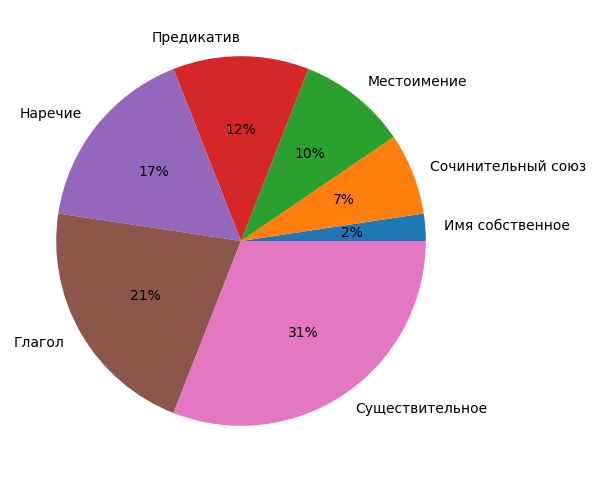

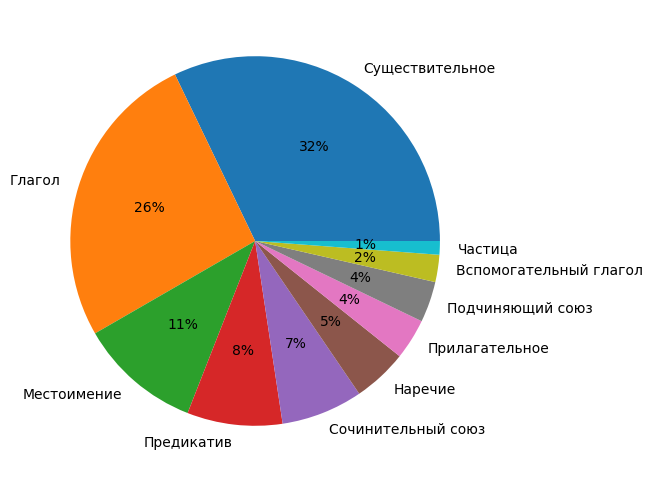

['Существительное',
 'Глагол',
 'Местоимение',
 'Предикатив',
 'Сочинительный союз',
 'Наречие',
 'Прилагательное',
 'Подчиняющий союз',
 'Вспомогательный глагол',
 'Частица']

In [15]:
def get_pos_distr(text) -> Dict:
  count = 0
  pos_dict = {
    'ADJ': 0,
    'ADV': 0,
    'INTJ': 0,
    'NOUN': 0,
    'PROPN': 0,
    'VERB': 0,

    'ADP': 0,
    'AUX': 0,
    'CCONJ': 0,
    'DET': 0,
    'NUM': 0,
    'PART': 0,
    'PRON': 0,
    'SCONJ': 0,

    'PUNCT': 0,
    'SYM': 0,
    'X': 0
}
  for token, pos in get_pos(text):
    # print(token, pos)
    if pos == 'PUNCT':
      continue

    pos_dict[pos] = pos_dict.setdefault(pos, 0) + 1

  return pos_dict

def get_pos_count(text, pos) -> int:
  return get_pos_distr(text).get(pos.upper(), 0)

def get_pos_count_percent(text, pos) -> float:
  count = len(tokenize_wrapper(text))
  return round(get_pos_distr(text).get(pos.upper(), 0) / count, 2)

#create pie chart
text = 'Птенца, там, мама птенцы, потом она улетела , и кошка пришла. Потом она стала залезать на дерево, потом прыгнула. Потом мама пришла у нее и спасла их. И собака зарычала на кошку. Потом собака за хвост дернула за кота. Потом выгнала кот собака.'
text2 = 'мальчик строил башенку, она у него получалась, но он поставил лишний кубик и она развалилась	потому что у него башенка развалилась	он поставил лишний кубик только что я сказала	будет дальше строить	кошка играла с цветком, кошка уронила цветок, упал цветок на собаку, собака разозлилась, нет, цветок упал на грабли и грабля дала кошке по носу	мама сказала девочке "сейчас мы будем пить чай", а девочка забыла что мама сказала, и побежала играть в игрушки, а потом когда девочку мама позвала.., девочка задела чашку'

pos_distr = get_pos_distr(text)
labels = [TRANSLATE_POS[pos] for pos, v in sorted(pos_distr.items(), key=lambda k: k[1]) if v != 0]
values = [pos_distr[k] for k, v in sorted(pos_distr.items(), key=lambda k: k[1]) if v != 0]

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%.0f%%')
plt.show()
labels

pos_distr = get_pos_distr(text2)
labels = [TRANSLATE_POS[pos] for pos, v in sorted(pos_distr.items(), key=lambda k: k[1], reverse=True) if v != 0]
values = [pos_distr[k] for k, v in sorted(pos_distr.items(), key=lambda k: k[1], reverse=True) if v != 0]

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%.0f%%')
plt.show()
labels

# Кореференция

In [16]:
# Инициализация:
from __future__ import annotations

!pip install natasha
!pip install ipymarkup

from natasha import (
    Segmenter, MorphVocab,
    NewsEmbedding, NewsMorphTagger, NewsSyntaxParser,
    Doc
)
import natasha
import ipymarkup
from typing import Any, List, Dict, Tuple, Optional, Set
import os
import json
import re

from itertools import combinations

from enum import Enum

# Инициализация моделей из Natasha:
g_segmenter = Segmenter()
emb = NewsEmbedding()
g_morph_tagger = NewsMorphTagger(emb)
g_syntax_parser = NewsSyntaxParser(emb)

## Синтаксический анализ

In [17]:
def build_tokens_list(a_text: str) -> Dict[str, natasha.doc.DocToken]:
    """
    Получение списка токенов из текста. Токены объединены в набор несвязных синтаксических деревьев,
    по одному на каждое предложение. Каждый токен хранит ссылку на своего предка в дереве.

    :param a_text: Входной текст.
    :return: Словарь токенов типа natasha.doc.DocToken. Ключами играют роль номера токенов
    DocToken#id, перевести которые в число невозможно. Ключи отсортированы по встрече
    соответствующих слов в тексте.
    """
    doc = Doc(a_text)
    doc.segment(g_segmenter)
    doc.tag_morph(g_morph_tagger)
    doc.parse_syntax(g_syntax_parser)

    # Составление словаря:
    map: Dict[str, natasha.doc.DocToken] = dict()
    for token in doc.tokens:
        map[token.id] = token

    return map


def draw_syntax_tree(a_tokens: Dict[str, natasha.doc.DocToken], a_drawer: Any, **kwargs) -> None:
    """
    Функция для отрисовки дерева. Принимает последним аргументом функцию, которая занимается
    отрисовкой.

    :param a_text: Список токенов типа natasha.doc.DocToken.
    :param a_drawer: Функция рисования.
    :param kwargs: Именованные аргументы для a_drawer.
    """
    new_id_to_old_id = {}
    counter: int = 0
    for token in a_tokens.values():
        if token.id not in new_id_to_old_id.keys():
            new_id_to_old_id[token.id] = counter
            counter += 1

    words, deps = [], []
    for token in a_tokens.values():
        words.append(token.text)
        source = new_id_to_old_id[token.head_id] if token.head_id in new_id_to_old_id.keys() else -1
        target = new_id_to_old_id[token.id]
        if source > 0 and source != target:
            deps.append([source, target, token.rel])

    a_drawer(words, deps, **kwargs)


def draw_ascii_syntax_tree(a_tokens: Dict[str, natasha.doc.DocToken], **kwargs) -> None:
    """
    Отрисовка синтаксического дерева в виде консольного вывода.

    См. draw_syntax_tree() выше.

    :param a_text: Список токенов типа natasha.doc.DocToken.
    :param kwargs: Именованные аргументы для a_drawer.
    """
    draw_syntax_tree(a_tokens, ipymarkup.show_dep_ascii_markup, **kwargs)


def draw_html_syntax_tree(a_tokens: Dict[str, natasha.doc.DocToken], **kwargs) -> None:
    """
    Отрисовка синтаксического дерева в виде html-картинки.

    :param a_text: Список токенов типа natasha.doc.DocToken.
    :param kwargs: Именованные аргументы для a_drawer.
    """
    draw_syntax_tree(a_tokens, ipymarkup.show_dep_markup, **kwargs)

Вспомогательные функции

In [18]:
def get_statisctics(l, text=None):
  text = '' if text is None else text.strip()+' '

  print(f"MAX {text}- {np.max(l)}")
  print(f"MIN {text}- {np.min(l)}")
  print(f"MEAN {text}- {np.mean(l)}")
  print(f"MEDIAN {text}- {np.median(l)}")

## Поиск именных групп по синтаксическому дереву

In [19]:
class Referent:
    """
    Структура для референта. Содержит список именных групп, которые ссылаются на неё.
    """

    def __init__(self, a_first: NounPhrase):
        self.m_noun_phrases: List[NounPhrase] = [a_first]


    def __str__(self) -> str:
        return self.m_noun_phrases[0].head_text()


class NounPhrase:
    """
    Сткрутура для хранения информации по именной группе в необработанном виде, как есть.
    """

    def __init__(
        self,
        a_head: natasha.doc.DocToken,
        a_dom_noun_phrase: Optional[NounPhrase] = None,
        a_dom_verb_phrase: Optional[natasha.doc.DocToken] = None):

        self.m_head: natasha.doc.DocToken = a_head

        # Ближайшая доминирующая именная группа:
        self.m_dom_noun_phrase: Optional[NounPhrase] = a_dom_noun_phrase

        # Ближайшая доминирующая глагольная группа:
        self.m_dom_verb_phrase: Optional[natasha.doc.DocToken] = a_dom_verb_phrase

        # Крайне левый токен именной группы:
        self.m_far_left_word: natasha.doc.DocToken = a_head

        # Крайне правый токен именной группы:
        self.m_far_right_word: natasha.doc.DocToken = a_head

        # Ссылка на именную группу-перечисление, к которой, если, принадлежит данная именная группа:
        self.m_conjunct: Optional[NounPhrase] = None

        # Ссылка на референт:
        self.m_referent: Optional[Referent] = Referent(self)


    def __str__(self) -> str:
        return f'{self.m_head.id} {self.m_head.text}'
        # return f'{self.m_head.id} {self.m_head.text} ' \
        #        f'({self.m_far_left_word.id}:{self.m_far_right_word.id}) ' \
        #        f'{self.m_dom_noun_phrase.text} {self.m_dom_verb_phrase.text}'


    def head_text(self) -> str:
        """
        :return: Запись слова-вершины в виде строки.
        """
        return self.m_head.text


    def head_pos(self) -> str:
        """
        :return: Часть речи вершины.
        """
        return self.m_head.pos


    def head_feats(self) -> List[Dict[str, str]]:
        """
        :return: Грамматические признаки вершины.
        """
        return self.m_head.feats


    def head_rel(self) -> List[Dict[str, str]]:
        """
        :return: Синтаксическая роль вершины.
        """
        return self.m_head.rel


    def sentence_id(self) -> int:
        """
        :return: Номер предложения.
        """
        return int(self.m_head.id.split('_')[0])


    def head_id_in_sentence(self) -> int:
        """
        :return: Позиция вершины в предложении.
        """
        return int(self.m_head.id.split('_')[1])


def is_a_head_of_noun_phrase(a_token: natasha.doc.DocToken) -> bool:
    """
    Проверка, является однозначно ли токен a_token вершиной некой именной группы. Существуют именные
    группы, которые не будут проходить эту проверу: перечисления.

    :param a_token: Входной текст.
    :return: True или является, и False иначе.
    """
    return a_token.rel in ['nsubj', 'nsubj:pass', 'obl', 'iobj', 'obj', 'xcomp', 'appos'] and \
           a_token.pos not in ['PUNCT', 'X', 'ADP', 'ADJ', 'ADV' 'SCONJ', 'DET', 'VERB', 'NUM']


def is_a_head_of_verb_phrase(a_token: natasha.doc.DocToken) -> bool:
    """
    Проверка, является однозначно ли токен a_token вершиной некой глагольной группы. Существуют
    глагольные группы, которые не будут проходить эту проверу: перечисления.

    :param a_token: Входной текст.
    :return: True или является, и False иначе.
    """
    return a_token.rel == 'root' and a_token.pos is 'VERB'


def is_a_conjunct(a_token: natasha.doc.DocToken) -> bool:
    """
    Проверка, является ли токен a_token элементом последовательности перечислений, как правило
    разделённых запятой или союзами 'и' или 'или'.

    :param a_token: Входной текст.
    :return: True или является, и False иначе.
    """
    return a_token.rel == 'conj'


def get_all_noun_phrases(a_tokens: Dict[str, natasha.doc.DocToken]) -> Dict[str, NounPhrase]:
    """
    Поиск всех именных групп в синтаксическом дереве a_tokens при помощи системы правил.

    :param a_tokens: Токены входного текста, отсортированные по порядку встречи соответствующих
    слов.
    :return: Словарь объектов типа NounPhrase -- найденных именных групп, отсортированных по порядку
    встречи их вершин в тексте. Ключами выступают значения DocToken#id вершин соответствующих
    именных групп.
    """

    # Список найденных именных групп:
    res: Dict[str, NounPhrase] = dict()

    # Рекурсивная функция, преследующая цель обнаружить ближайшие доминирующие именную группу и
    # глагольную группу, а так же обновить для первой значения m_far_left_word и m_far_right_word.
    def rec_find_dom(a_token: natasha.doc.DocToken) -> \
        Tuple[Optional[NounPhrase], Optional[natasha.doc.DocToken]]:
        """

        :param a_token: Входной токен.
        :return: Пара из ближайших доминирующих именной и глагольной групп.
        """

        it: Optional[natasha.doc.DocToken] = a_tokens.get(a_token.id)
        while True:
            # Случай отсутствия очередного предка:
            if it is None:
                return None, None
            # Случай, когда очередной предок оказывается вершиной именной группы:
            elif is_a_head_of_noun_phrase(it):

                # Создать объект именной группы если необходимо:
                if it.id in res.keys():
                    np = res[it.id]
                else:
                    try:
                        np = NounPhrase(it, *rec_find_dom(a_tokens.get(it.head_id)))
                        res[it.id] = np
                    except RecursionError:
                        print('rec!')
                        return None, it

                # Обновить m_far_left_word для np:
                if a_token.start < np.m_far_left_word.start:
                    np.m_far_left_word = a_token

                # Обновить m_far_right_word для np:
                if np.m_far_right_word.start < a_token.start:
                    np.m_far_right_word = a_token

                # Обновить m_conjunct для np:
                if is_a_conjunct(a_token):

                    # Создать объект именной группы для a_token:
                    old_np = NounPhrase(a_token)
                    res[a_token.id] = old_np

                    # Создать объект именной группы-перечисления если необходимо:
                    if np.m_conjunct is None:
                        conjunct_np = NounPhrase(it, np.m_dom_noun_phrase, np.m_dom_verb_phrase)
                        # Установить для np доминирующей именной группой conjunct_np:
                        np.m_dom_noun_phrase = conjunct_np
                        res[it.id + '_conjunct'] = conjunct_np
                    else:
                        conjunct_np = np.m_conjunct

                    # Установить и для old_np то же самое что и для np:
                    old_np.m_dom_noun_phrase = conjunct_np
                    old_np.m_dom_verb_phrase = np.m_dom_verb_phrase

                    res[a_token.id].m_conjunct = conjunct_np

                return np, np.m_dom_verb_phrase
            # Случай, когда очередной предок оказывается вершиной глагольной группы:
            elif is_a_head_of_verb_phrase(it):
                return None, it

            # Установить итератор на предка текущего токена:
            it = a_tokens.get(it.head_id)

    # Переберём все токены и проверим, являются ли они вершиной именной группы:
    for token in a_tokens.values():
        rec_find_dom(token)

    return res


def draw_noun_phrases_in_text(
    a_text: str, a_noun_phrases: Dict[str, NounPhrase], a_drawer: Any, **kwargs) -> None:
    """
    Нарисовать текст с обозначенными именными группами. Принимает последним аргументом функцию,
    которая занимается отрисовкой.

    :param a_text: Исходный текст.
    :param a_noun_phrases: Словарь объектов типа NounPhrase, отсортированных по порядку встречи их
    вершин в тексте. Ключами выступают значения DocToken#id вершин соответствующих именных групп.
    :param a_drawer: Функция рисования.
    :param kwargs: Именованные аргументы для a_drawer.
    """

    # Составить список отрезков:
    lines: List[Tuple[int, int, str]] = []
    for np in a_noun_phrases.values():
        if np.m_referent is None:
            lines.append((np.m_far_left_word.start, np.m_far_right_word.stop,
                          np.head_text()))
        else:
            lines.append((np.m_far_left_word.start, np.m_far_right_word.stop,
                          np.m_referent.m_noun_phrases[-1].head_text()))

    a_drawer(a_text, lines, **kwargs)


def draw_ascii_noun_phrases_in_text(
    a_text: str, a_noun_phrases: Dict[str, NounPhrase], **kwargs) -> None:
    """
    Нарисовать текст с обозначенными именными группами в виде консольного вывода.

    :param a_text: Исходный текст.
    :param a_noun_phrases: Словарь объектов типа NounPhrase, отсортированных по порядку встречи их
    вершин в тексте. Ключами выступают значения DocToken#id вершин соответствующих именных групп.
    :param kwargs: Именованные аргументы для a_drawer.
    """
    draw_noun_phrases_in_text(a_text, a_noun_phrases, ipymarkup.show_span_ascii_markup, **kwargs)


def draw_html_noun_phrases_in_text(
    a_text: str, a_noun_phrases: Dict[str, NounPhrase], **kwargs) -> None:
    """
    Нарисовать текст с обозначенными именными группами в виде html-картинки.

    :param a_text: Исходный текст.
    :param a_noun_phrases: Словарь объектов типа NounPhrase, отсортированных по порядку встречи их
    вершин в тексте. Ключами выступают значения DocToken#id вершин соответствующих именных групп.
    :param kwargs: Именованные аргументы для a_drawer.
    """
    draw_noun_phrases_in_text(a_text, a_noun_phrases, ipymarkup.show_span_line_markup, **kwargs)

<>:115: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:115: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-19-adb40402a94a>:115: SyntaxWarning: "is" with a literal. Did you mean "=="?
  return a_token.rel == 'root' and a_token.pos is 'VERB'


# Синтаксис предложения

In [20]:
text = 'Человек должен стремиться к высшей цели. Жила-была птичка. У нее. Она жила на югу в дубу. И у нее были птенцы. Однажды птенцы захотели кушать. Их мама птичка улетела за едой, а котик увидел птичек, которые остались одни, ну птенцов, и захотел их скушать. А когда мама улетела, потом она вернулась с ягодками, а котик уже начал взбираться на дерево. Потом котик забрался к гнезду и тут прибежала собака. Собака увидела, что котик хочет съесть птенцов и погналась за кошкой. Собака схватила за хвост кошку, а мама в то время видела, что кошка хотела съесть её птенцов, а собака вытащила кошку с дерева и погналась за кошкой. '
text = 'Мальчик разбил, а потом на девочку наговаривает.'
syntax_parser = NewsSyntaxParser(emb)

doc = Doc(text)
doc.segment(segmenter)
doc.parse_syntax(syntax_parser)
print(doc.tokens)
doc.sents[0].syntax.print()

[DocToken(stop=7, text='Мальчик', id='1_1', head_id='1_2', rel='nsubj'), DocToken(start=8, stop=14, text='разбил', id='1_2', head_id='1_0', rel='root'), DocToken(start=14, stop=15, text=',', id='1_3', head_id='1_8', rel='punct'), DocToken(start=16, stop=17, text='а', id='1_4', head_id='1_8', rel='cc'), DocToken(start=18, stop=23, text='потом', id='1_5', head_id='1_8', rel='advmod'), DocToken(start=24, stop=26, text='на', id='1_6', head_id='1_7', rel='case'), DocToken(start=27, stop=34, text='девочку', id='1_7', head_id='1_8', rel='obl'), DocToken(start=35, stop=47, text='наговаривает', id='1_8', head_id='1_2', rel='conj'), DocToken(start=47, stop=48, text='.', id='1_9', head_id='1_2', rel='punct')]
            ┌► Мальчик      nsubj
┌─┌─────────└─ разбил       
│ │ ┌────────► ,            punct
│ │ │ ┌──────► а            cc
│ │ │ │ ┌────► потом        advmod
│ │ │ │ │   ┌► на           case
│ │ │ │ │ ┌►└─ девочку      obl
│ └►└─└─└─└─── наговаривает conj
└────────────► .            pun

In [21]:
text = 'Человек должен стремиться к высшей цели. Жила-была птичка. У нее. Она жила на югу в дубу. И у нее были птенцы. Однажды птенцы захотели кушать. Их мама птичка улетела за едой, а котик увидел птичек, которые остались одни, ну птенцов, и захотел их скушать. А когда мама улетела, потом она вернулась с ягодками, а котик уже начал взбираться на дерево. Потом котик забрался к гнезду и тут прибежала собака. Собака увидела, что котик хочет съесть птенцов и погналась за кошкой. Собака схватила за хвост кошку, а мама в то время видела, что кошка хотела съесть её птенцов, а собака вытащила кошку с дерева и погналась за кошкой. '
text = 'и палкой кошке прямо в нос,     '
syntax_parser = NewsSyntaxParser(emb)

doc = Doc(text)
doc.segment(segmenter)
doc.parse_syntax(syntax_parser)
print(doc.tokens)
doc.sents[0].syntax.print()

[DocToken(stop=1, text='и', id='1_1', head_id='1_2', rel='cc'), DocToken(start=2, stop=8, text='палкой', id='1_2', head_id='1_3', rel='amod'), DocToken(start=9, stop=14, text='кошке', id='1_3', head_id='1_2', rel='iobj'), DocToken(start=15, stop=20, text='прямо', id='1_4', head_id='1_6', rel='advmod'), DocToken(start=21, stop=22, text='в', id='1_5', head_id='1_6', rel='case'), DocToken(start=23, stop=26, text='нос', id='1_6', head_id='1_3', rel='nmod'), DocToken(start=26, stop=27, text=',', id='1_7', head_id='1_3', rel='punct')]
        ┌► и      cc
    ┌─┌►└─ палкой amod
┌─┌─└►└─── кошке  iobj
│ │   ┌──► прямо  advmod
│ │   │ ┌► в      case
│ └──►└─└─ нос    nmod
└────────► ,      punct


In [22]:
syntax_parser = NewsSyntaxParser(emb)

class SyntaxTree:
  def __init__(self, text):
    self.doc = Doc(text)
    self.doc.segment(segmenter)
    self.doc.parse_syntax(syntax_parser)

    self.count_sents = len(self.doc.sents)
    print(self.doc.text)

  def get_roots_by_sent(self, n_sent):
    roots = []
    for token in self.doc.sents[n_sent].syntax.tokens:
      if token.rel == 'root':
        roots.append((token.id, token.text))

    return roots

  def print_tree(self, n_sent: int):
    self.doc.sents[n_sent].syntax.print()

  def get_num(self, id: str):
    return int(id[id.index('_')+1:])

  def get_ids_by_text(self, text: str, n_sent: int):
    ids = []
    for token in self.doc.sents[n_sent].syntax.tokens:
      if token.text == text:
        ids.append(self.get_num(token.id))
    return ids

  def token_parents(self, token_text: str, n_sent: int):
    # TODO переделать на id
    parents = []
    for token in self.doc.sents[n_sent].syntax.tokens:
      if token.text == token_text and token.rel != 'root':
        parents.append(self.doc.sents[n_sent].syntax.tokens[self.get_num(token.head_id)])
    return parents

  def token_children(self, token_id: str, n_sent: int):
    children = []
    for child_token in self.doc.sents[n_sent].syntax.tokens:
      if child_token.head_id == token_id and child_token.rel != 'punct':
        children.append((child_token.id, child_token.text))
    return children

  def get_rels(self, depth: int):
    def rec_get_rels(rels: List, word_id: str, n_sent: int, prev_words: List):
      children = self.token_children(word_id, n_sent)
      if children:
        for child_id, child_text in children:
          if len(prev_words) == depth-1:
            rels.append(prev_words + [child_text.lower()])
            rec_get_rels(rels, child_id, n_sent, prev_words[1:] + [child_text.lower()])
          else:
            rec_get_rels(rels, child_id, n_sent, prev_words + [child_text.lower()] )

    rels = []

    if depth == 1:
      for token in self.doc.tokens:
        if token.rel != 'punct':
          rels.append([token.text.lower()])
    else:
      for n_sent in range(self.count_sents):
        for root_id, root_text in self.get_roots_by_sent(n_sent):
          rec_get_rels(rels, root_id, n_sent, [root_text.lower()])

    return rels

  def test(self):
    for n_sent in range(self.count_sents):
      print(tree.doc.sents[n_sent])


## 1. Смысловая полнота

Смысловая полнота рассказа, которая оценивается суммой баллов, начисляемой за упоминание ключевых моментов.

3 балла ставятся, если ребенок  самостоятельно упоминает их в рассказе;

1,5 балла — если называет после вопросов психолога, или при нeтoчнoм опрeдeлeнии объeкта или дeйствия,

0 баллов — отсутствиe упоминания.

In [23]:
text = 'Человек должен стремиться к высшей цели. Жила-была птичка. У нее. Она жила на югу в дубу. И у нее были птенцы. Однажды птенцы захотели кушать. Их мама птичка улетела за едой, а котик увидел птичек, которые остались одни, ну птенцов, и захотел их скушать. А когда мама улетела, потом она вернулась с ягодками, а котик уже начал взбираться на дерево. Потом котик забрался к гнезду и тут прибежала собака. Собака увидела, что котик хочет съесть птенцов и погналась за кошкой. Собака схватила за хвост кошку, а мама в то время видела, что кошка хотела съесть её птенцов, а собака вытащила кошку с дерева и погналась за кошкой. '
# text = 'Собака схватила за хвост кошку, а мама в то время видела, что кошка хотела съесть её птенцов, а собака вытащила кошку с дерева и погналась за кошкой.'

tree = SyntaxTree(text)
print(tree.count_sents)
tree.get_rels(1)

Человек должен стремиться к высшей цели. Жила-была птичка. У нее. Она жила на югу в дубу. И у нее были птенцы. Однажды птенцы захотели кушать. Их мама птичка улетела за едой, а котик увидел птичек, которые остались одни, ну птенцов, и захотел их скушать. А когда мама улетела, потом она вернулась с ягодками, а котик уже начал взбираться на дерево. Потом котик забрался к гнезду и тут прибежала собака. Собака увидела, что котик хочет съесть птенцов и погналась за кошкой. Собака схватила за хвост кошку, а мама в то время видела, что кошка хотела съесть её птенцов, а собака вытащила кошку с дерева и погналась за кошкой. 
11


[['человек'],
 ['должен'],
 ['стремиться'],
 ['к'],
 ['высшей'],
 ['цели'],
 ['жила-была'],
 ['птичка'],
 ['у'],
 ['нее'],
 ['она'],
 ['жила'],
 ['на'],
 ['югу'],
 ['в'],
 ['дубу'],
 ['и'],
 ['у'],
 ['нее'],
 ['были'],
 ['птенцы'],
 ['однажды'],
 ['птенцы'],
 ['захотели'],
 ['кушать'],
 ['их'],
 ['мама'],
 ['птичка'],
 ['улетела'],
 ['за'],
 ['едой'],
 ['а'],
 ['котик'],
 ['увидел'],
 ['птичек'],
 ['которые'],
 ['остались'],
 ['одни'],
 ['ну'],
 ['птенцов'],
 ['и'],
 ['захотел'],
 ['их'],
 ['скушать'],
 ['а'],
 ['когда'],
 ['мама'],
 ['улетела'],
 ['потом'],
 ['она'],
 ['вернулась'],
 ['с'],
 ['ягодками'],
 ['а'],
 ['котик'],
 ['уже'],
 ['начал'],
 ['взбираться'],
 ['на'],
 ['дерево'],
 ['потом'],
 ['котик'],
 ['забрался'],
 ['к'],
 ['гнезду'],
 ['и'],
 ['тут'],
 ['прибежала'],
 ['собака'],
 ['собака'],
 ['увидела'],
 ['что'],
 ['котик'],
 ['хочет'],
 ['съесть'],
 ['птенцов'],
 ['и'],
 ['погналась'],
 ['за'],
 ['кошкой'],
 ['собака'],
 ['схватила'],
 ['за'],
 ['хвост'],
 ['кошку'],
 ['

In [24]:
SentencesPreprocessor().normalize_sentence('поругать')

['поругать']

In [25]:
synonymizer = synonymizer_parser
synonymizer.get_synonyms('башня')

{'Батура',
 'Биг-Бен',
 'башен',
 'башенка',
 'башка',
 'башня',
 'бельведер',
 'беффруа',
 'бык',
 'вежа',
 'великан',
 'верея',
 'вита',
 'вольверк',
 'высотка',
 'вышка',
 'гелеполь',
 'голова',
 'гопурам',
 'гуляй-городок',
 'дворец',
 'дом',
 'донжон',
 'здание',
 'зиккурат',
 'каланча',
 'кешк',
 'кибитка',
 'колокольня',
 'колонна',
 'корм',
 'котелок',
 'кровля',
 'крыша',
 'купол',
 'курия',
 'луковка',
 'маковка',
 'маяк',
 'маячок',
 'минарет',
 'минибашня',
 'минорет',
 'наверх',
 'небоскреб',
 'нураг',
 'общество',
 'ограда',
 'пагода',
 'пилон',
 'пирамида',
 'пиргос',
 'повалуша',
 'пристройка',
 'пьедестал',
 'радиобашня',
 'ратуша',
 'репа',
 'ротонда',
 'святилище',
 'силос',
 'смотрильня',
 'сооружение',
 'стамбха',
 'столб',
 'столп',
 'стрельница',
 'стрельня',
 'таа',
 'телебашня',
 'тур',
 'устой',
 'фала',
 'храм',
 'часть',
 'шатер',
 'шинхара',
 'шпиль'}

In [26]:
synonymizer.get_synonyms('гнездо')

{'блюдечко',
 'борозда',
 'вертеп',
 'вместилище',
 'вмятина',
 'воронка',
 'впадина',
 'выбоина',
 'выемка',
 'вымоина',
 'газырь',
 'гайнище',
 'гайно',
 'глубь',
 'гнездилище',
 'гнездо',
 'гнездовина',
 'гнездовище',
 'гнездовье',
 'гнездышко',
 'голубятня',
 'дом',
 'домик',
 'дупло',
 'дуплянка',
 'жерло',
 'жилище',
 'жилплощадь',
 'жилье',
 'жильё',
 'имение',
 'источник',
 'канавка',
 'квартира',
 'колдобина',
 'котловина',
 'кров',
 'кровля',
 'крыша',
 'кубло',
 'куча',
 'логово',
 'ложбинка',
 'ложка',
 'лунка',
 'место',
 'муравейник',
 'наверх',
 'ниша',
 'нора',
 'норка',
 'обиталище',
 'орава',
 'очаг',
 'паз',
 'патрон',
 'пещера',
 'полость',
 'поместье',
 'помещение',
 'прибежище',
 'пристанище',
 'притон',
 'приют',
 'пятник',
 'разъем',
 'рассадник',
 'розетка',
 'семейство',
 'семья',
 'скоп',
 'скопление',
 'стан',
 'станица',
 'стая',
 'степс',
 'стреха',
 'тайник',
 'термитник',
 'трущоба',
 'убежище',
 'угол',
 'укрытие',
 'ургана',
 'усадьба',
 'ухаб',
 'хран

In [27]:
DEFAULT_PREFIXES = ('а','агит','ан','англо','анти','атто','без','бес','брам','в','вз','вне','военно','воз','вос','вы','гекса','гексаконта','гекта','гекто','гепта','гептаконта','гига',
'гипер','гор','гос','де','дез','дека','деци','дикта','до','додека','за','зепто','зетта','из','изо','ин','интервики','интра','инфра','йокто','йотта','квадра','квази','кила','кило',
'ко','кое','контр','лейб','мега','меж','микро','милли','мини','мириа','моно','на','над','наи','нано','не','недо','ни','низ','нис','нона','о','около','окта','октаконта','от','па','пара',
'пентаконта','пере','пета','пико','по','под','после','пост','пра','пре','пред','при','про','прото','раз','ре','роз','рос','с','санти','сверх','со','су','суб','супер','супра','сюр','тера',
'тетра','тетраконта','транс','тре','три','триаконта','тридека','трикта','у','ультра','ундека','фемто','черес','эйкоза','экзо','экс','экса','экстра','эннеаконта')

In [28]:
def calc_semantic_completeness(text, semantic_components):
  # semantic_components = ['птица', 'мама', 'птенцы', 'кот', 'схватить', 'кормит', 'отвернулась', 'собака', 'схватила', 'спасла', 'прогнала'] # 0.73
  # semantic_components = ['девочка', 'мама', 'мальчик', 'чашки', 'стол', 'осколки', 'ругать', 'девочку', 'прячется', 'блюдце']
  # «Гнездо» 1 птица-мама;  2 птенцы;  3 котик;  4 хочет схватить птенца;  5 кормит птенцов;  6 отвернулась;  7 собака;  8 схватила кота;  9 спасла птенцов;  10 прогнала кота)
  def compare_lists(l1, l2):
    if len(l1) != len(l2):
      raise Exception(f'Длина списков не совпадает: {len(l1)} != {len(l2)}')

    for i in range(len(l1)):
      if l1[i] == l2[i]:
        continue
      w1, w2 = (l1[i], l2[i]) if len(l1[i]) < len(l2[i]) else (l2[i], l1[i])

      if w2 not in list(map(lambda prefix: prefix + w1, DEFAULT_PREFIXES)):
        return False

    return True

  def get_comp_synonyms(comps):
    if type(comps) is not list:
      comps = [comps]
    synonymizer = synonymizer_parser

    comp_synonyms = []
    for comp in comps:
      for comp in product(*[token.split('/') for token in comp.split(' ')]):
        comp_synonyms_list = [synonymizer.get_synonyms(comp_word) for comp_word in comp]

        # print(comp_synonyms_list)
        for comp_synonym in product(*comp_synonyms_list):
          comp_synonyms.append(list(comp_synonym))

    return comp_synonyms

  sent_preprocess = SentencesPreprocessor()
  norm_text = sent_preprocess.normalize_sentence(text)
  # text = text.replace('.', ',')

  count = 0

  tree = SyntaxTree(text)
  rels_dict = {}
  for i in range(1, 4):
    rels_dict[i] = []
    for rel in tree.get_rels(i):
      prep_rel = sent_preprocess.normalize_iter(rel)
      if len(prep_rel) == i:
        rels_dict[i].append(prep_rel)

  print(rels_dict[2])
  for comp in semantic_components:
    find_flag = False
    for prep_comp_synonym in get_comp_synonyms(comp):
      # print(f'prep_comp_synonym = {prep_comp_synonym}')
      for prep_rel in rels_dict.get(len(prep_comp_synonym), []):
        # prep_rel = sent_preprocess.normalize_iter(rel)
        # print(f'--{prep_rel} ||| {prep_comp_synonym}')
        # stem_prep_rel = list(map(stemmer.stem, prep_rel))
        # stem_prep_comp_synonym = list(map(stemmer.stem, prep_comp_synonym))
        # print(f'--{stem_prep_rel} ||| {stem_prep_comp_synonym}')

        if len(prep_comp_synonym) and len(prep_rel) and compare_lists(prep_rel, prep_comp_synonym):
          print(f'--{prep_rel} ||| {prep_comp_synonym}')
          count += 1
          find_flag = True
          break
      if find_flag:
        break

  return round(count/len(semantic_components), 2)

## 2. Смысловая адекватность А и Б

0 баллов ставится, если в рассказе верно передан смысл происходящего.

Смысловая адекватность оценивается два раза: по наличию ошибок левополушарного и правополушарного типа.

Смыслoвая неадекватнoсть из-за слабoсти левoпoлушарных функций oценивается oт oднoгo дo трех баллoв.

1 балл ставится за пропуск одного из ключевых смысловых звеньев, самостоятельно корригируемый.

2 балла – при пропуске 1-2 ключевых смысловых звеньев.

3 балла подразумевает пропуск трех и более смысловых звеньев, сохраняющийся после наводящих вопросов.


Смысловая неадекватность из-за слабости правополушарных функций также может быть оценена от одного до трех баллов.

1 балл начисляется за нарушение связи между событиями при верном их описании.

2 балла – при ошибочном толковании событий с ошибочным восприятием или игнорированием 1-2 компонентов картинок.

При нереалистическом толковании событий с игнорированием нескольких компонентов картинок ставятся 3 балла.



## 3. Прогрaммировaние рaсскaзa.

0 бaллов – рaсскaз включaет основные смысловые единицы в прaвильной последовaтельности и с нaличием связующих звеньев.

1 балл – пропуск отдельных смысловых единиц, отсутствие связующих звеньев или наличие необоснованных повторов связующих слов.

2 балла – пропуск смысловых звеньев, тенденция к перечислению деталей, наличие смысловых повторов и разрывов в повествовании.

3 балла – отсутствие  связного текста.




## 4. Грамматическое оформление рассказа

От 0 баллов за грамматически правильно оформленный рассказ с использованием разных грамматических конструкций;

до 3 баллов, если допускаются множественные синтаксические ошибки, в том числе пропуск глагольного сказуемого.




## 5. Количество параграмматизмов

(Вики) Парагматизм - это нарушение разговорной речи в результате повреждения различных областей мозга, вызывающее то, что известно как афазия (языковые расстройства). Прагматизм можно разделить на беглые афазии, то есть те, при которых затронутые люди могут выражать себя без усилий, с небольшими нарушениями артикуляции, но с отсутствием содержания, словарного запаса речи и т. Д.

Люди, пострадавшие от прагматизм как правило дезорганизовывать предложения, заменяя правильные формы неправильными грамматическими формами.

Нaпpимеp, "Галка пepеoдeлась 6eлым цветoм" - веpбaльнaя зaменa "пеpеoделась" вместo "пoкpаcилaсь" влечет зa сoбoй oшибкy yпpaвления

## 6. Длина рассказа (количество слов и предложений)  (DONE)

Количество слов в самостоятельном рассказе, а также количество в рассказе, включая ответы на вопросы.

In [30]:
print(f'Количество слов в тексте: {len(tokenize_wrapper(ex.tell))}')
print(f'Количество предложений в тексте: {len(sentenize_wrapper(ex.tell))}')
print(f'Количество уникальных слов в тексте: {len(get_word_uniq(ex.tell))}\n')

print(f'Количество слов в тексте, включая ответы на вопросы: {len(tokenize_wrapper(ex.tell + ex.answer))}')
print(f'Количество предложений в тексте, включая ответы на вопросы: {len(sentenize_wrapper(ex.tell + ex.answer))}')
print(f'Количество уникальных слов в тексте, включая ответы на вопросы: {len(get_word_uniq(ex.tell + ex.answer))}')

NameError: name 'ex' is not defined

## 7. Количество сложных предложений (DONE)


In [33]:
def count_compound_sentences(tell):
  count_sentences = len(sentenize_wrapper(tell))
  count_compound_sentences = len([sent for sent in sentenize_wrapper(tell) if sent.count(',') > 0])
  return count_compound_sentences

def count_compound_sentences_percent(tell):
  count_sentences = len(sentenize_wrapper(tell))
  count_compound_sentences = len([sent for sent in sentenize_wrapper(tell) if sent.count(',') > 0])
  return round(count_compound_sentences/count_sentences, 2)

# print(f'Количество сложных предложений: {count_compound_sentences(ex.tell)}')
# print(f'Процент сложных предложений: {count_compound_sentences_percent(ex.tell)}')

## 8. Средняя длина фразы (DONE)


In [34]:
def mean_sentences_len(tell):
  sentences_len = list(map(lambda x: len(tokenize_wrapper(x)), sentenize_wrapper(tell)))
  return np.mean(sentences_len)

# sentences_len = list(map(lambda x: len(tokenize_wrapper(x)), sentenize_wrapper(ex.tell)))
# get_statisctics(sentences_len, text = 'количество слов в предложении')
# print('\n')

# sentences_len = list(map(lambda x: len(preprocess(x)), sentenize_wrapper(ex.tell)))
# get_statisctics(sentences_len, text = 'количество уникальных слов в предложении')

## 9. Правильные ответы на вопросы (???)


## 10. Лексическое оформление рассказа.

0 баллов ставится при адекватном использовании лексических средств ребенком.

1 – при поиске слов или единичных близких вербальных заменах.

2 балла подразумевают бедность словаря, вербальные парафазии.

3 – это выраженная бедность словаря, множественные лексические ошибки.

## 11. Разнообразие словаря (TTR) (DONE)

Лексическое разнообразие словаря (Type-Token Ratio в англоязычной традиции);


TTR = количество уникальных лексем, или лемм, в анализируемом тексте /  количество текстоформ (общее количество словоформ) в анализируемом тексте

In [39]:
def ttr(tell):
  return round(len(get_word_uniq(tell))/len(preprocess(tell)), 2)

# print(f'TTR = {ttr(ex.tell)}')


## 12. Прономинализация (DONE)

Показатель прономинализации - количество местоимений и их удельный вес в текстах;


In [ ]:
print(f'Количество местоимений - {get_pos_count(ex.tell, "PRON")}')
print(f'Удельный вес местоимений - {get_pos_count_percent(ex.tell, "PRON")}')

## 13. Количество атрибутов (прилагательных и наречий) (DONE)


In [ ]:
print(f'Количество прилагательных - {get_pos_count(ex.tell, "ADJ")}')
print(f'Удельный вес прилагательных - {get_pos_count_percent(ex.tell, "ADJ")}\n')

print(f'Количество наречий - {get_pos_count(ex.tell, "ADV")}')
print(f'Удельный вес наречий - {get_pos_count_percent(ex.tell, "ADV")}')

# Кластеризация

## Датасет дошкольников

# Обработка датасета дошкольников


In [36]:
#path_data_speech = '/content/gdrive/MyDrive/Diplom/Тексты детей по РФ и эмоциям_parsed.csv'
path_data_speech = '/content/gdrive/MyDrive/Diplom/parsed_test_new.csv'
df_new = pd.read_csv(path_data_speech)
df_new.fillna('', inplace=True)
df_new

,name,text,is_strong,count_numbers,tell1,order1,answer1,time1,tell2,tell2_prep,order2,time2,tell3,tell3_prep,time3
0,Ребенок1,"девочка не могла решить, что ей съесть. они по...",1,,"девочка не могла решить, что ей съесть. они по...",,,23,он проснулся. потом он насыпал хлопья и пролил...,,,17,Там инопланетная собака и несколько инопланетн...,,36
1,Ребенок2,"эм, они пошли в Макдональдс и мальчик заказал ...",1,,"эм, они пошли в Макдональдс и мальчик заказал ...",,,17,"Однажды маленький мальчик обнаружил, что у нег...",,,19,Жили-были маленькая девочка и мальчик. Они шли...,,35
2,Ребенок3,"Эм, они не смогли получить еду, потому что их ...",1,,"Эм, они не смогли получить еду, потому что их ...",,,42,Однажды проснулся маленький мальчик. его разбу...,,,24,Однажды мальчик и девочка отправились на поиск...,,43
3,Ребенок4,"Жили-были двое детей и мама. и она спросила, г...",1,,"Жили-были двое детей и мама. и она спросила, г...",,,36,однажды мальчик проснулся с кровати. потом он ...,,,20,Однажды на настоящую Землю пришли четверо иноп...,,35
4,Ребенок5,"Мама Лизы забрала детей и сказала, что мы соби...",1,,"Мама Лизы забрала детей и сказала, что мы соби...",,,45,Джейк встал с кровати. и он налил немного моло...,,,25,Дэниел и Мишель осмотрели кусты. они увидели к...,,27
5,Ребенок6,во вторник их мать спросила хотят ли дети пой...,1,,во вторник их мать спросила хотят ли дети пой...,,,55,Джеймса разбудил будильник. он выбежал из свое...,,,46,Жили-были мальчик по имени Бобби и девочка по ...,,52
6,Ребенок7,Рэймонд и Лиза вернулись из школы. и их мать с...,1,,Рэймонд и Лиза вернулись из школы. и их мать с...,,,40,Однажды утром Джим проснулся. и пытался поесть...,,,46,однажды в дом переехала новая семья из ххх. и ...,,17
7,Ребенок8,"когда Рэймонд и Лиза вернулись из школы, мать ...",1,,"когда Рэймонд и Лиза вернулись из школы, мать ...",,,39,Однажды Макс проснулся. хе-хе он опоздал. он п...,,,28,однажды Джеймс и Саманта гуляли в парке. они ...,,25
8,Ребенок9,"эм, они хотят пойти в Макдональдс. и мальчик з...",1,,"эм, они хотят пойти в Макдональдс. и мальчик з...",,,18,"есть парень, который проснулся и он посмотрел ...",,,25,когда-то на Землю пришли какие-то инопланетяне...,,28
9,Ребенок10,"Мать Рэймонда спросила их, не хотят ли они схо...",1,,"Мать Рэймонда спросила их, не хотят ли они схо...",,,36,"И-эм, маленький мальчик вставал с кровати. и э...",,,35,"эм, этот большой корабль пришёл на-эм-землю ма...",,27


In [ ]:
df1 = df_new[['order1', 'time1', 'is_strong']]
df1['tell1'] = df_new['tell1'].map(lambda s: re.sub('\.{2,} ?', ' ', s.replace('\t', ' ')))
df1 = df1[df1['tell1'] != '']
df1

<ipython-input-51-54d97099e0f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tell1'] = df_new['tell1'].map(lambda s: re.sub('\.{2,} ?', ' ', s.replace('\t', ' ')))


,order1,time1,is_strong,tell1
0,,23,1,"девочка не могла решить, что ей съесть. они по..."
1,,17,1,"эм, они пошли в Макдональдс и мальчик заказал ..."
2,,42,1,"Эм, они не смогли получить еду, потому что их ..."
3,,36,1,"Жили-были двое детей и мама. и она спросила, г..."
4,,45,1,"Мама Лизы забрала детей и сказала, что мы соби..."
5,,55,1,во вторник их мать спросила хотят ли дети пой...
6,,40,1,Рэймонд и Лиза вернулись из школы. и их мать с...
7,,39,1,"когда Рэймонд и Лиза вернулись из школы, мать ..."
8,,18,1,"эм, они хотят пойти в Макдональдс. и мальчик з..."
9,,36,1,"Мать Рэймонда спросила их, не хотят ли они схо..."


In [ ]:
df2 = df_new[['order2', 'time2', 'is_strong']]
df2['tell2'] = df_new['tell2'].map(lambda s: re.sub('\.{2,} ?', ' ', s.replace('\t', ' ')))
df2 = df2[df2['tell2'] != '']
df2

<ipython-input-52-70b7c0fe0c8b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['tell2'] = df_new['tell2'].map(lambda s: re.sub('\.{2,} ?', ' ', s.replace('\t', ' ')))


,order2,time2,is_strong,tell2
0,,17,1,он проснулся. потом он насыпал хлопья и пролил...
1,,19,1,"Однажды маленький мальчик обнаружил, что у нег..."
2,,24,1,Однажды проснулся маленький мальчик. его разбу...
3,,20,1,однажды мальчик проснулся с кровати. потом он ...
4,,25,1,Джейк встал с кровати. и он налил немного моло...
5,,46,1,Джеймса разбудил будильник. он выбежал из свое...
6,,46,1,Однажды утром Джим проснулся. и пытался поесть...
7,,28,1,Однажды Макс проснулся. хе-хе он опоздал. он п...
8,,25,1,"есть парень, который проснулся и он посмотрел ..."
9,,35,1,"И-эм, маленький мальчик вставал с кровати. и э..."


In [ ]:
df3 = df_new[['time3', 'is_strong']]
df3['tell3'] = df_new['tell3'].map(lambda s: re.sub('\.{2,} ?', ' ', s.replace('\t', ' ')))
df3 = df3[df3['tell3'] != '']
df3

<ipython-input-53-639d2c0e572c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['tell3'] = df_new['tell3'].map(lambda s: re.sub('\.{2,} ?', ' ', s.replace('\t', ' ')))


,time3,is_strong,tell3
0,36,1,Там инопланетная собака и несколько инопланетн...
1,35,1,Жили-были маленькая девочка и мальчик. Они шли...
2,43,1,Однажды мальчик и девочка отправились на поиск...
3,35,1,Однажды на настоящую Землю пришли четверо иноп...
4,27,1,Дэниел и Мишель осмотрели кусты. они увидели к...
5,52,1,Жили-были мальчик по имени Бобби и девочка по ...
6,17,1,однажды в дом переехала новая семья из ххх. и ...
7,25,1,однажды Джеймс и Саманта гуляли в парке. они ...
8,28,1,когда-то на Землю пришли какие-то инопланетяне...
9,27,1,"эм, этот большой корабль пришёл на-эм-землю ма..."


In [37]:
def create_attrs(tell, semantic_components):
  df = pd.concat([tell, tell.apply(lambda s: len(tokenize_wrapper(s)))], axis=1)
  df = pd.concat([df, tell.apply(lambda s: len(sentenize_wrapper(s)))], axis=1)
  df = pd.concat([df, tell.apply(lambda s: len(get_word_uniq(s)))], axis=1)
  df = pd.concat([df, tell.apply(count_compound_sentences_percent)], axis=1)
  df = pd.concat([df, tell.apply(mean_sentences_len)], axis=1)
  df = pd.concat([df, tell.apply(ttr)], axis=1)
  df = pd.concat([df, tell.apply(lambda s: get_pos_count_percent(s, "ADJ"))], axis=1)
  df = pd.concat([df, tell.apply(lambda s: get_pos_count_percent(s, "ADV"))], axis=1)
  df = pd.concat([df, tell.apply(lambda s: get_pos_count_percent(s, "PRON"))], axis=1)
  df = pd.concat([df, tell.apply(lambda s: get_pos_count_percent(s, "NOUN"))], axis=1)
  df = pd.concat([df, tell.apply(lambda s: get_pos_count_percent(s, "VERB"))], axis=1)
  df = pd.concat([df, tell.apply(lambda s: calc_semantic_completeness(s, semantic_components[0]))], axis=1)
  df = pd.concat([df, tell.apply(lambda s: calc_semantic_completeness(s, semantic_components[1]))], axis=1)
  df = pd.concat([df, tell.apply(lambda s: calc_semantic_completeness(s, semantic_components[2]))], axis=1)

  df.columns = [tell.name] + ['Кол-во слов', 'Кол-во предл', 'Кол-во уник. слов', 'Кол-во слож предл', 'Средняя длина предл',
                'TTR', 'Проц прил', 'Проц наречий', 'Проц мест', 'Проц сущ', 'Проц глаг', 'Семант полнота',
                'Сущ сем комп', 'Действия сем комп']

  return df


In [38]:
def get_df(df, postfix, semantic_components):
  df_cor = create_attrs(df[f'tell{postfix}'], semantic_components).iloc[:, 1:]
  df_cor['time'] = df[f'time{postfix}']
  df_cor['is_strong'] = df['is_strong']
  return df_cor

In [ ]:
def get_heatmap(df_cor):
  plt.figure(figsize=(10,5))
  sns.heatmap(df_cor.corr(), annot = True, vmin=-1, vmax=1, center= 0)

1) кошка, киска, котенок
2) сидит на окне (на подоконнике)
3) увидел/а собаку
4) хочет навредить
5) сбросил цветочный горшок
6) рядом стояли грабли
7) цветок упал на грабли
8) из-за этого (или подразумеваемая связь)
9) грабли стукнули котенка
10) собака не пострадала

In [ ]:
Semantic_components = namedtuple('Semantic_components', ['full' , 'entities', 'actions'])

In [ ]:
# Semantic_components = namedtuple('Semantic_components', ['full' , 'entities', 'actions'])
semantic_components_full = ['мама/мать спросила/сказала', 'дети/мальчик и девочка вернулись/пришли школы', 'мальчик/мама/девочка хотел/знал/решил/заказал', 'оставила/забыла сумку/кошелек/деньги']
semantic_components_entities = ['мама/мать', 'дети' 'девочка', 'мальчик', 'еда', 'чизбургер', 'сумка/кошелек', 'Макдональдс/ресторан', 'дома', 'чизбургер/сэндвич', 'коктейль', 'мороженое/рожок', 'салат', 'кола', 'хэппи мил', 'школа', 'продавец/кассир']
semantic_components_actions = ['вернулись', 'спросила/сказала', 'кричали' 'сели', 'поехали/пошли', 'не знала/решила', 'заказать', 'хотел/знали', 'забыла/оставила']
semantic_components1 = Semantic_components(semantic_components_full, semantic_components_entities, semantic_components_actions)

semantic_components_full = ['мальчик проснулся/встал', 'посмотрел время/часы', 'разлил молоко', 'опоздал школу/автобус', 'порвались/сломались шнурки/веревки', 'автобус ушел/уехал']
semantic_components_entities = ['мальчик', 'хлопья', 'молоко', 'шнурки/веревки','ботинки', 'автобус', 'школа', 'учитель', 'время/часы']
semantic_components_actions = ['проснулся', 'посмотрел', 'разлил', 'порвал/сломал', 'опоздал','побежал/пошел']
semantic_components2 = Semantic_components(semantic_components_full, semantic_components_entities, semantic_components_actions)

semantic_components_full =  ['мальчик/брат напугал/испугался', 'девочка/сестра посмотреть/подружиться/увидеть', 'нло/инопланеняне/пришельцы упала/приземлилась/прилетела']
semantic_components_entities = ['мальчик/брат', 'девочка/сестра','нло/инопланеняне/пришельцы', 'космический корабль', 'мама','папа', 'собака', 'люди', 'дети/ребенок', 'родители']
semantic_components_actions = ['гуляли', 'увидели','упала/приземлилась/прилетела','посмотреть/подружиться', 'испугался/боялся', 'спрятался','вернулись', 'не поверили']
semantic_components3 = Semantic_components(semantic_components_full, semantic_components_entities, semantic_components_actions)

In [ ]:
semp_comps = {"semp_comp1": semantic_components1, "semp_comp2": semantic_components2, "semp_comp3": semantic_components3}

In [ ]:
# clusters1 = []
# for df, postfix, semantic_components in zip([df1, df2, df3], list(range(1, 4)), [semantic_components1, semantic_components2, semantic_components3]):
#   df_cor = get_df(df, str(postfix), semantic_components)
#   clusters1.append(get_clusters(df_cor))

In [ ]:
clusters = {}
semp_comps = {"semp_comp1": semantic_components1, "semp_comp2": semantic_components2, "semp_comp3": semantic_components3}
df_cors = []

for df, postfix, semantic_components_i in zip([df1, df2, df3], list(range(1, 4)), semp_comps.items()):
  key = semantic_components_i[0]  # Извлечение ключа из кортежа (например, "semp_comp1")
  df_cor = get_df(df, str(postfix), semantic_components_i[1])  # Использование значения как аргумента
  df_cors.append(df_cor)
  # clusters[key] = get_clusters(df_cor)  # Использование ключа как ключа для словаря "clusters"

df_cors = dict(zip(semp_comps.keys(), df_cors))

девочка не могла решить, что ей съесть. они пошли в Макдональдс.и они вошли. а потом их мать заплатила за еду. она потянулась за сумочкой. и она не смогла его найти.
[['мочь', 'девочка'], ['мочь', 'решить'], ['решить', 'заплатить'], ['заплатить', 'она'], ['заплатить', 'они'], ['заплатить', 'потом'], ['заплатить', 'мать'], ['заплатить', 'ехать'], ['мочь', 'пойти'], ['мочь', 'войти'], ['войти', 'съесть'], ['съесть', 'что'], ['войти', 'они'], ['войти', 'она'], ['мочь', 'потянуться'], ['потянуться', 'макдональдс'], ['потянуться', 'сумочка'], ['мочь', 'смочь'], ['смочь', 'она'], ['смочь', 'найти'], ['найти', 'его']]
эм, они пошли в Макдональдс и мальчик заказал чизбургер и мама заказала салат. и маленькая девочка заказала рожок шоколадного мороженого. мама забыла дома сумочку.и это всё, что я помню
[['заказать', 'макдональдс'], ['заказать', 'чизбургер'], ['чизбургер', 'мальчик'], ['чизбургер', 'мама'], ['заказать', 'салат'], ['заказать', 'мама'], ['заказать', 'дом'], ['заказать', 'сумочка']

In [ ]:
# df_cors = dict(zip(semp_comps.keys(), df_cors))

In [ ]:
df_cors

{'semp_comp1':     Кол-во слов  Кол-во предл  Кол-во уник. слов  Кол-во слож предл  \
 0            31             1                 18               1.00   
 1            30             1                 20               1.00   
 2            75             2                 38               1.00   
 3            81             1                 39               1.00   
 4            76             4                 39               1.00   
 5           158             1                 74               1.00   
 6            96             3                 49               0.67   
 7           103             5                 52               0.60   
 8            38             1                 25               1.00   
 9            91             1                 41               1.00   
 10           28             4                 12               0.75   
 11           40             3                 20               0.33   
 12           14             1                  8 

In [ ]:
for cor in df_cors.values():
  print(cor)

Метрики для всех датафреймов

In [ ]:
df_combined2 = pd.concat(df_cors, axis=1)
df_combined2

semp_comp1                                                   \
   Кол-во слов Кол-во предл Кол-во уник. слов Кол-во слож предл   
0           31            1                18              1.00   
1           30            1                20              1.00   
2           75            2                38              1.00   
3           81            1                39              1.00   
4           76            4                39              1.00   
5          158            1                74              1.00   
6           96            3                49              0.67   
7          103            5                52              0.60   
8           38            1                25              1.00   
9           91            1                41              1.00   
10          28            4                12              0.75   
11          40            3                20              0.33   
12          14            1                 8              1.00   
13          12            3                 7              0.33   
14          39            1                21              1.00   
15           2            1                 1              0.00   
16           1            1                 1              0.00   
17          11            1                 6              1.00   
18          12            1                 6              1.00   
19           2            1                 1              0.00   
20          25            3                18              0.00   
21          52            2                23              0.50   
22          34            5                22              0.60   
23          57            2                31              0.50   
24          56            7                30              0.43   
25          28            1                15              1.00   
26          76            2                41              1.00   
27          94            2                41              1.00   
28          69            1                36              1.00   
29          43            3                20              1.00   
30          62            2                32              1.00   
31          79            2                38              1.00   
32          19            2                11              1.00   
33          70            1                38              1.00   
34          26            1                20              0.00   
35          46            3                26              0.33   
36          34            1                20              1.00   
37          82            2                41              1.00   
38          21            2                12              0.00   
39          79            1                39              1.00   
40          41            2                25              0.50   
41          41            6                26              0.33   
42          56            6                28              0.50   
43          46            7                22              0.29   
44          12            2                 8              0.00   
45          20            4                14              0.25   
46          66            5                36              0.80   
47          14            1                11              1.00   
48         118           10                57              0.90   
49          13            2                 9              1.00   
50          92           10                39              0.70   
51          64            8                32              0.75   
52         101            9                52              0.89   
53         108           12                50              0.50   
54          88           12                44              0.33   
55           9            1                 6              1.00   
56          11            1                 6              1.00   
57          16            3                 9      

In [ ]:
import pandas as pd
from google.colab import files
csv_file = 'data_ch.csv'
df_combined2.to_csv(csv_file, index=False)
files.download(csv_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_combined2 = pd.read_csv('https://docs.google.com/spreadsheets/d/1_bYd5iRxzbC34bbTDlL_0aVbMKttACZAv4UkoDadu7o/export?format=csv&gid=1072126418', header=1)

#Обучение моделей с разными семантическими компонентами

In [ ]:
# для 6 разных
all_clusters = []
clusters = {}
for key, df_cor_value in df_cors.items():
  print(df_cor_value.shape)
  scaler = preprocessing.StandardScaler().fit(df_cor_value)
  df_cor_scaled = scaler.transform(df_cor_value)
  kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
  clusters[key] = kmeans
  clustering = kmeans.fit_predict(df_cor_scaled)
  print(f"Ключ: {key}")
  print(f"Метки кластеров: {clustering}")
  print()
  all_clusters.append(clustering)
  all_clusters

NameError: name 'df_cors' is not defined

In [ ]:
all_clusters

[array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0], dtype=int32),
 array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1], dtype=int32),
 array([1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0], dtype=int32)]

In [ ]:
all_clusters[0] = np.append(all_clusters[0], 1)
list(zip(*all_clusters))

[(0, 1, 1),
 (1, 0, 1),
 (1, 0, 1),
 (1, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 1),
 (0, 1, 0),
 (0, 1, 0),
 (0, 1, 0),
 (0, 1, 0),
 (0, 1, 0),
 (0, 1, 0),
 (0, 1, 0),
 (0, 1, 0),
 (0, 1, 0),
 (0, 1, 0),
 (1, 1, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 1, 1),
 (1, 1, 0),
 (0, 0, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 1),
 (1, 1, 1),
 (1, 1, 1),
 (1, 0, 1),
 (0, 0, 0),
 (1, 0, 0),
 (0, 0, 1),
 (0, 0, 0),
 (0, 1, 0),
 (1, 0, 0),
 (0, 1, 0),
 (1, 0, 0),
 (1, 1, 1),
 (1, 0, 1),
 (1, 1, 1),
 (1, 1, 0),
 (0, 1, 0),
 (0, 1, 1),
 (1, 1, 1),
 (0, 0, 1),
 (1, 0, 1),
 (0, 0, 1),
 (1, 1, 0),
 (1, 1, 0),
 (1, 0, 1),
 (1, 1, 1),
 (1, 1, 1),
 (0, 1, 0),
 (0, 0, 0),
 (0, 1, 0),
 (1, 1, 0),
 (0, 1, 0)]

In [ ]:
for i, c in enumerate(zip(*all_clusters)):
  cnt = Counter(c)
  print(f'{i} - {cnt.most_common(1)[0][0]}')

0 - 1
1 - 1
2 - 1
3 - 1
4 - 0
5 - 1
6 - 0
7 - 0
8 - 1
9 - 1
10 - 0
11 - 0
12 - 0
13 - 0
14 - 0
15 - 0
16 - 0
17 - 0
18 - 0
19 - 0
20 - 1
21 - 0
22 - 0
23 - 1
24 - 1
25 - 0
26 - 0
27 - 1
28 - 1
29 - 1
30 - 1
31 - 1
32 - 0
33 - 0
34 - 0
35 - 0
36 - 0
37 - 0
38 - 0
39 - 0
40 - 1
41 - 1
42 - 1
43 - 1
44 - 0
45 - 1
46 - 1
47 - 0
48 - 1
49 - 0
50 - 1
51 - 1
52 - 1
53 - 1
54 - 1
55 - 0
56 - 0
57 - 0
58 - 1
59 - 0


### Визуализация(Сделать нормально)

In [ ]:
for key, df_cor_value in df_cors.items():
  sns.displot(data=df_cor_value, x='Кол-во слов', hue='is_strong')

In [ ]:
# фигня
import matplotlib.pyplot as plt

for key, clustering in clusters.items():
    x = df_cor_value.iloc[:, -1]
    y = df_cor_value.iloc[:, 0]

    plt.scatter(x[:len(clustering.labels_)], y[:len(clustering.labels_)], c=clustering.labels_)
    plt.xlabel("tell")
    plt.ylabel("time")
    plt.title(key)
    plt.show()

# Сохранение модели на диск

In [ ]:
import joblib

path_drive = "/content/gdrive/MyDrive/Diplom/"  # путь к директории на диске

for key, cluster in clusters.items():
    filepath = path_drive + key + ".joblib"
    joblib.dump(cluster, filepath)

# Загрузка модели

In [ ]:
import joblib
import pandas as pd

path_drive = "/content/gdrive/MyDrive/Diplom/"  # путь к директории на диске

loaded_clusters = {}

for key in semp_comps.keys():
    filepath = path_drive + key + ".joblib"
    loaded_clusters[key] = joblib.load(filepath)

In [ ]:
loaded_clusters

{'semp_comp1': KMeans(n_clusters=2, n_init=10, random_state=0),
 'semp_comp2': KMeans(n_clusters=2, n_init=10, random_state=0),
 'semp_comp3': KMeans(n_clusters=2, n_init=10, random_state=0)}

# Предсказание

In [ ]:
#для загуженной модели, для незагруженной изменить переменную loaded_clusters на clusters
def predict(sem_component, df_child):
  df_cor_new = create_attrs(df_child.iloc[:, -1], semp_comps[sem_component]).iloc[:, 1:]
  df_cor_new['time'] = df_child.iloc[:, 0]
  df_cor_new['is_strong'] = df_child.iloc[:, 1]
  clustering_new_data = loaded_clusters[sem_component].predict(df_cor_new)
  print(df_cor_new)
  return clustering_new_data

### Предсказание по одному тексту

In [ ]:
df2 = pd.DataFrame({
  "time2": ["13"],
  "is_strong": ["1"],
  "tell2": ["собака спала, кошка сидела на окне и уронила цветок. Цветок упал на грабли и грабли стукнули кошке в лицо."]
})
res = predict("semp_comp2", df2)
print('Результат класстеризации:', res[0])

собака спала, кошка сидела на окне и уронила цветок. Цветок упал на грабли и грабли стукнули кошке в лицо.
[['спать', 'собака'], ['сидеть', 'кошка'], ['сидеть', 'окно'], ['сидеть', 'уронить'], ['уронить', 'цветок'], ['упасть', 'цветок'], ['упасть', 'стукнули'], ['стукнули', 'грабли'], ['грабли', 'грабли'], ['стукнули', 'кошка'], ['стукнули', 'лицо']]
--['кошка'] ||| ['кошка']
--['собака'] ||| ['собака']
--['сидеть'] ||| ['подсидеть']
--['уронить', 'цветок'] ||| ['уронить', 'цветок']
--['стукнули', 'лицо'] ||| ['стукнули', 'лицо']
собака спала, кошка сидела на окне и уронила цветок. Цветок упал на грабли и грабли стукнули кошке в лицо.
[['спать', 'собака'], ['сидеть', 'кошка'], ['сидеть', 'окно'], ['сидеть', 'уронить'], ['уронить', 'цветок'], ['упасть', 'цветок'], ['упасть', 'стукнули'], ['стукнули', 'грабли'], ['грабли', 'грабли'], ['стукнули', 'кошка'], ['стукнули', 'лицо']]
--['кошка'] ||| ['кошка']
--['собака'] ||| ['собака']
--['цветок'] ||| ['цветок']
--['грабли'] ||| ['грабли']
с

### Предсказание по нескольким текстам

In [ ]:
# df1 = pd.DataFrame({
#   "time1": ["10"],
#   "is_strong": ["1"],
#   "tell1": ["мальчик построил большую башню из кубиков. Она у него упала, потому что была неровная, и сломалась. "]
# })

# df2 = pd.DataFrame({
#   "time2": ["13"],
#   "is_strong": ["1"],
#   "tell2": ["собака спала, кошка сидела на окне и уронила цветок. Цветок упал на грабли и грабли стукнули кошке в лицо."]
# })

# df3 = pd.DataFrame({
#   "time3": ["14"],
#   "is_strong": ["1"],
#   "tell3": ["Мальчик мячом бросил и в чашку попал. И мама пришла и подумала что это дочка. А это был братик ее. Он спрятался потому что он виноват, а не дочка. "]
# })
df1 = pd.DataFrame({ "time1": [43], "is_strong": [1], "tell1": ["Я не помню имени маленького мальчика. однажды эти двое вернулись домой из школы. их мать сказала, что они собирались поесть в тот вечер . и она спросила их, куда они хотят пойти. они оба  кричали «Макдональдс». Когда они приехали, Лиза не могла решить, что хочет.  Итак, ее мать и брат уже знали, чего хотят. ее брат попросил ээ  когда он добрался до стойки, он попросил чизбургер с картошкой фри и ванильный молочный коктейль. их мать заказала немного салата. наконец-то Лиза смогла решить, чего она хочет. она попросила хэппи мил с рожком мороженого и колой. как раз в тот момент, когда их мать полезла в свою сумочку, чтобы достать сумку, его там не было. и она вспомнила, что оставила сумочку на дома."]})
df2 = pd.DataFrame({ "time2": [30], "is_strong": [1], "tell2": ["однажды маленький мальчик по имени Сэмми проснулся от того, что его будильник звонил очень-очень громко. он быстро спустился вниз, чтобы позавтракать. и как раз в тот момент, когда он наливал молоко в хлопья, он случайно пролил молоко на стол. после того, как он оделся в школу, его шнурки не слушались. и они бы вообще не связались. он собирался в школу идя по улице.  и его школьный автобус уезжал. он бежал за ним, но он не успел вовремя. так что ему пришлось идти в школу пешком. его учитель сказал, что он очень сильно опоздал ."]})
df3 = pd.DataFrame({ "time3": [36], "is_strong": [1], "tell3": ["Однажды двое детей шли по тропинке. Это было утро понедельника. они прошли мимо этого  леса. они решили отправиться туда ради небольшого приключения и, возможно, просто ради улиток, которых они еще не видели. они видели этих инопланетян. оба ребенка были напуганы, но девочка не очень-то испугалась. мальчик был в ужасе. Маргарет побежала к инопланетянам, пока Дэниел держал ее руку и говорил «нет». а потом инопланетяне прыгнули на корабль. и они просто разошлись всей семьей. но они пошли домой, отвели родителей к тому месту, где они видели <&~ar>[/] инопланетян, чтобы посмотреть, там ли они еще. родители сказали, что в это не очень легко поверить."]})


In [ ]:
dfs = [("semp_comp1", df1), ("semp_comp2", df2), ("semp_comp3", df3)]

res = []
for semp_comp, df in dfs:
  print(semp_comp)
  print(df)
  res.append(predict(semp_comp, df)[0])


semp_comp1
   time1  is_strong                                              tell1
0     43          1  Я не помню имени маленького мальчика. однажды ...
Я не помню имени маленького мальчика. однажды эти двое вернулись домой из школы. их мать сказала, что они собирались поесть в тот вечер . и она спросила их, куда они хотят пойти. они оба  кричали «Макдональдс». Когда они приехали, Лиза не могла решить, что хочет.  Итак, ее мать и брат уже знали, чего хотят. ее брат попросил ээ  когда он добрался до стойки, он попросил чизбургер с картошкой фри и ванильный молочный коктейль. их мать заказала немного салата. наконец-то Лиза смогла решить, чего она хочет. она попросила хэппи мил с рожком мороженого и колой. как раз в тот момент, когда их мать полезла в свою сумочку, чтобы достать сумку, его там не было. и она вспомнила, что оставила сумочку на дома.
[['помнить', 'вернуться'], ['вернуться', 'однажды'], ['вернуться', 'двое'], ['двое', 'этот'], ['вернуться', 'домой'], ['помнить', 'спросить']

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


однажды маленький мальчик по имени Сэмми проснулся от того, что его будильник звонил очень-очень громко. он быстро спустился вниз, чтобы позавтракать. и как раз в тот момент, когда он наливал молоко в хлопья, он случайно пролил молоко на стол. после того, как он оделся в школу, его шнурки не слушались. и они бы вообще не связались. он собирался в школу идя по улице.  и его школьный автобус уезжал. он бежал за ним, но он не успел вовремя. так что ему пришлось идти в школу пешком. его учитель сказал, что он очень сильно опоздал .
[['проснуться', 'мальчик'], ['мальчик', 'маленький'], ['мальчик', 'имя'], ['имя', 'сэмми'], ['проснуться', 'тот'], ['тот', 'спуститься'], ['спуститься', 'будильник'], ['будильник', 'его'], ['спуститься', 'быстро'], ['спуститься', 'вниз'], ['спуститься', 'автобус'], ['автобус', 'его'], ['автобус', 'его'], ['автобус', 'школьный'], ['спуститься', 'успеть'], ['успеть', 'вовремя'], ['спуститься', 'что'], ['тот', 'пролить'], ['пролить', 'однажды'], ['пролить', 'хлопья

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


Однажды двое детей шли по тропинке. Это было утро понедельника. они прошли мимо этого  леса. они решили отправиться туда ради небольшого приключения и, возможно, просто ради улиток, которых они еще не видели. они видели этих инопланетян. оба ребенка были напуганы, но девочка не очень-то испугалась. мальчик был в ужасе. Маргарет побежала к инопланетянам, пока Дэниел держал ее руку и говорил «нет». а потом инопланетяне прыгнули на корабль. и они просто разошлись всей семьей. но они пошли домой, отвели родителей к тому месту, где они видели <&~ar>[/] инопланетян, чтобы посмотреть, там ли они еще. родители сказали, что в это не очень легко поверить.
[['идти', 'однажды'], ['идти', 'ребенок'], ['ребенок', 'двое'], ['идти', 'тропинка'], ['утро', 'это'], ['утро', 'быть'], ['утро', 'понедельник'], ['напугать', 'пройти'], ['пройти', 'приключение'], ['приключение', 'ради'], ['приключение', 'небольшой'], ['напугать', 'решить'], ['решить', 'они'], ['решить', 'отправиться'], ['отправиться', 'лес'], 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [ ]:
res

[1, 0, 1]

In [ ]:
from collections import Counter

most_common = Counter(res).most_common(1)
most_common_result = most_common[0][0] if most_common else None

print('Результат кластеризации:', most_common_result)

Результат кластеризации: 1


# Оценка точности

In [ ]:
df = pd.DataFrame(df_combined2)
all_clusters = [1,1,1,1,0,1,0, 0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,1,0,1,1,1,1,1,0,0,0,1,0]
# Добавляем колонку "all_clusters"
df['all_clusters'] = all_clusters


In [ ]:
df

,Кол-во слов,Кол-во предл,Кол-во уник. слов,Кол-во слож предл,Средняя длина предл,TTR,Проц прил,Проц наречий,Проц мест,Проц сущ,...,Проц наречий.2,Проц мест.2,Проц сущ.2,Проц глаг.2,Семант полнота.2,Сущ сем комп.2,Действия сем комп.2,time.2,is_strong.2,all_clusters
0,31,1,18,1.00,31.000000,0.82,0.00,0.03,0.23,0.13,...,0.06,0.17,0.16,0.16,0.33,0.5,0.62,36,1,1
1,30,1,20,1.00,30.000000,0.87,0.07,0.03,0.17,0.33,...,0.10,0.09,0.26,0.19,0.67,0.7,0.75,35,1,1
2,75,2,38,1.00,37.500000,0.68,0.08,0.05,0.15,0.27,...,0.12,0.16,0.17,0.20,0.00,0.7,0.62,43,1,1
3,81,1,39,1.00,81.000000,0.68,0.05,0.11,0.07,0.23,...,0.14,0.14,0.13,0.19,0.00,0.5,0.50,35,1,1
4,76,4,39,1.00,19.000000,0.67,0.04,0.08,0.07,0.24,...,0.04,0.12,0.23,0.19,0.00,0.7,0.62,27,1,0
5,158,1,74,1.00,158.000000,0.63,0.06,0.11,0.14,0.17,...,0.10,0.17,0.12,0.20,0.00,0.9,0.88,52,1,1
6,96,3,49,0.67,32.000000,0.70,0.03,0.03,0.16,0.18,...,0.09,0.15,0.22,0.17,0.00,0.5,0.62,17,1,0
7,103,5,52,0.60,20.600000,0.67,0.04,0.06,0.09,0.20,...,0.09,0.19,0.12,0.21,0.00,0.0,0.75,25,1,0
8,38,1,25,1.00,38.000000,0.86,0.03,0.08,0.11,0.26,...,0.09,0.08,0.15,0.23,0.00,0.6,0.62,28,1,1
9,91,1,41,1.00,91.000000,0.66,0.04,0.03,0.15,0.15,...,0.08,0.08,0.29,0.12,0.33,0.8,0.50,27,1,1


In [ ]:
from sklearn.metrics import precision_score, f1_score

y_true = df['is_strong']
y_pred = df['all_clusters']
print("Precision Score:")
print(precision_score(y_true, y_pred))
print("\nF1 Score:")
print(f1_score(y_true, y_pred))

Precision Score:
0.9642857142857143

F1 Score:
0.7397260273972602


In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


true_labels = df['is_strong']
cluster_labels = df['all_clusters']

ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print("Adjusted Rand Index for", ari)
print("Normalized Mutual Information for", nmi)

Adjusted Rand Index for 0.12236246634459318
Normalized Mutual Information for 0.19937156931387842


#Модель объединенных метрик

In [ ]:
# df_cor_joined = pd.concat(df_cors.values(), axis=0, ignore_index=True) # TODO: для объединения
# df_cor_joined

In [ ]:
df_combined2 = pd.read_csv('https://docs.google.com/spreadsheets/d/1_bYd5iRxzbC34bbTDlL_0aVbMKttACZAv4UkoDadu7o/export?format=csv&gid=1072126418', header=1)

In [ ]:
date_tmp = pd.read_csv('https://docs.google.com/spreadsheets/d/1_bYd5iRxzbC34bbTDlL_0aVbMKttACZAv4UkoDadu7o/export?format=csv&gid=1072126418', header=1)

In [ ]:
df_combined2 = df_combined2.drop(['is_strong.2'], axis=1, errors='ignore')

# Кластеризация методом К-средних, Спектральная

In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(df_combined2.fillna(0))
df_cor_scaled = scaler.transform(df_combined2.fillna(0))

# Используем алгоритм K средних
kmeans_join = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans_clustering = kmeans_join.fit_predict(df_cor_scaled)

# Используем спектральную кластеризацию
spectral_join = SpectralClustering(n_clusters=2, affinity='nearest_neighbors')
spectral_clustering = spectral_join.fit_predict(df_cor_scaled)


print("KMeans Clustering:")
print(kmeans_clustering)

print("\nSpectral Clustering:")
print(spectral_clustering)

df_clastered = pd.DataFrame()
df_clastered = pd.concat([df_clastered, df_combined2], axis=1)
df_clastered["Claster K-means"] = kmeans_clustering
df_clastered["Claster Spectral"] = spectral_clustering
df_clastered


KMeans Clustering:
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0
 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]

Spectral Clustering:
[1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]


,Кол-во слов,Кол-во предл,Кол-во уник. слов,Кол-во слож предл,Средняя длина предл,TTR,Проц прил,Проц наречий,Проц мест,Проц сущ,...,Проц наречий.2,Проц мест.2,Проц сущ.2,Проц глаг.2,Семант полнота.2,Сущ сем комп.2,Действия сем комп.2,time.2,Claster K-means,Claster Spectral
0,31,1,18,1.00,31.000000,0.82,0.00,0.03,0.23,0.13,...,0.06,0.17,0.16,0.16,0.33,0.5,0.62,36,1,1
1,30,1,20,1.00,30.000000,0.87,0.07,0.03,0.17,0.33,...,0.10,0.09,0.26,0.19,0.67,0.7,0.75,35,1,0
2,75,2,38,1.00,37.500000,0.68,0.08,0.05,0.15,0.27,...,0.12,0.16,0.17,0.20,0.00,0.7,0.62,43,1,0
3,81,1,39,1.00,81.000000,0.68,0.05,0.11,0.07,0.23,...,0.14,0.14,0.13,0.19,0.00,0.5,0.50,35,1,0
4,76,4,39,1.00,19.000000,0.67,0.04,0.08,0.07,0.24,...,0.04,0.12,0.23,0.19,0.00,0.7,0.62,27,1,0
5,158,1,74,1.00,158.000000,0.63,0.06,0.11,0.14,0.17,...,0.10,0.17,0.12,0.20,0.00,0.9,0.88,52,1,0
6,96,3,49,0.67,32.000000,0.70,0.03,0.03,0.16,0.18,...,0.09,0.15,0.22,0.17,0.00,0.5,0.62,17,1,0
7,103,5,52,0.60,20.600000,0.67,0.04,0.06,0.09,0.20,...,0.09,0.19,0.12,0.21,0.00,0.0,0.75,25,1,0
8,38,1,25,1.00,38.000000,0.86,0.03,0.08,0.11,0.26,...,0.09,0.08,0.15,0.23,0.00,0.6,0.62,28,1,0
9,91,1,41,1.00,91.000000,0.66,0.04,0.03,0.15,0.15,...,0.08,0.08,0.29,0.12,0.33,0.8,0.50,27,1,0


# Визуализация

<ipython-input-79-b558d1ed5580>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_data.index, y='silhouette', data=feature_data, palette='Blues')


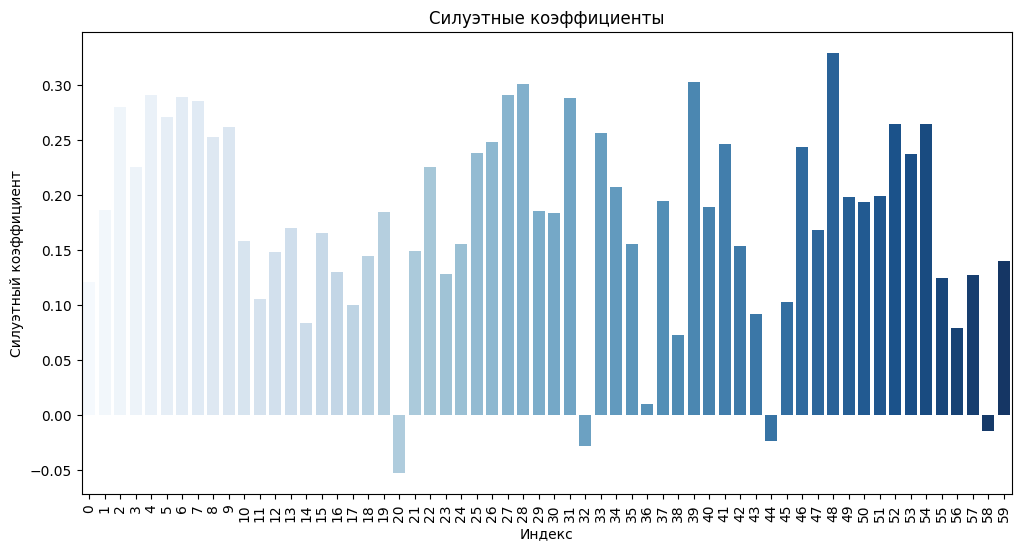

Средний силуэтный коэффициент: 0.17807679314225383


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
# Создаем DataFrame с силуэтными коэффициентами
silhouette_vals = silhouette_samples(df_cor_scaled, kmeans_clustering)
feature_data = pd.DataFrame({'silhouette': silhouette_vals})

# Сбрасываем индекс в feature_data
feature_data = feature_data.reset_index(drop=True)

# Визуализация силуэтных коэффициентов
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_data.index, y='silhouette', data=feature_data, palette='Blues')
plt.xticks(rotation=90)
plt.title('Силуэтные коэффициенты')
plt.xlabel('Индекс')
plt.ylabel('Силуэтный коэффициент')
plt.show()
silhouette_avg = silhouette_score(df_cor_scaled, kmeans_clustering)

print("Средний силуэтный коэффициент:", silhouette_avg)

<ipython-input-80-943a0cd0f97c>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_data.index, y='silhouette', data=feature_data, palette='Blues')


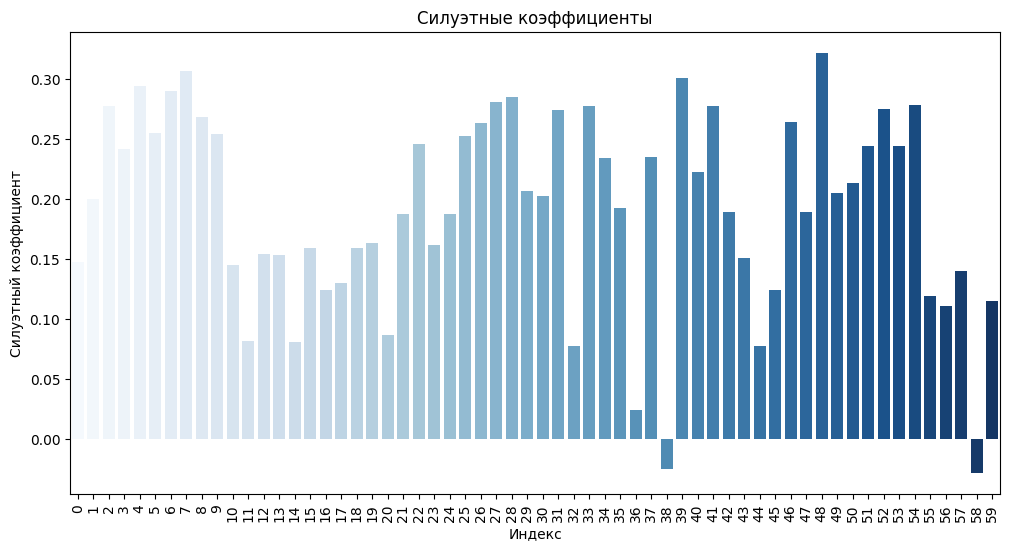

Средний силуэтный коэффициент: 0.19279184058629706


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
# Создаем DataFrame с силуэтными коэффициентами
silhouette_vals = silhouette_samples(df_cor_scaled, spectral_clustering)
feature_data = pd.DataFrame({'silhouette': silhouette_vals})

# Сбрасываем индекс в feature_data
feature_data = feature_data.reset_index(drop=True)

# Визуализация силуэтных коэффициентов
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_data.index, y='silhouette', data=feature_data, palette='Blues')
plt.xticks(rotation=90)
plt.title('Силуэтные коэффициенты')
plt.xlabel('Индекс')
plt.ylabel('Силуэтный коэффициент')
plt.show()
silhouette_avg = silhouette_score(df_cor_scaled, spectral_clustering)

print("Средний силуэтный коэффициент:", silhouette_avg)

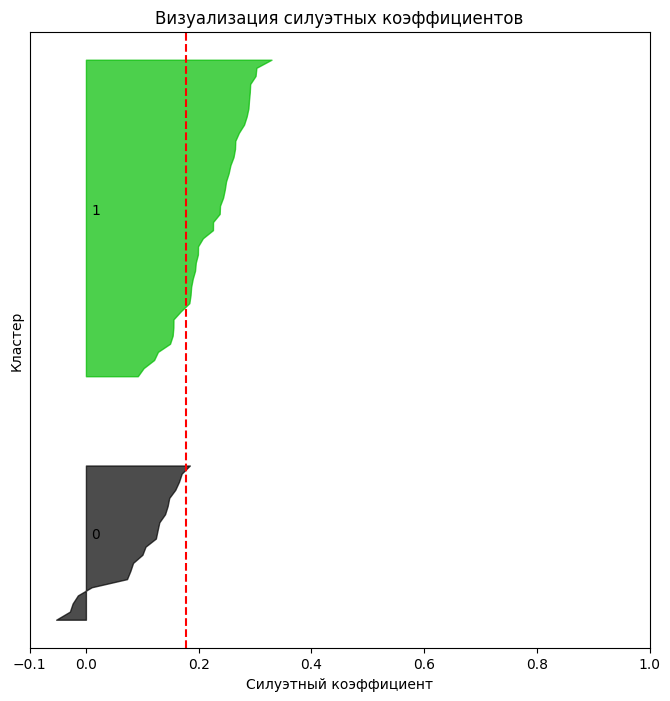

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Предположим, что kmeans_clustering содержит метки кластеров, а df_cor_scaled - ваши данные
silhouette_vals = silhouette_samples(df_cor_scaled, kmeans_clustering)
silhouette_avg = silhouette_score(df_cor_scaled, kmeans_clustering)

# Визуализация силуэтных коэффициентов
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
n_clusters = 2
y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = silhouette_vals[kmeans_clustering == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                    facecolor=color, edgecolor=color, alpha=0.7)

    ax.text(0.01, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

ax.set_title("Визуализация силуэтных коэффициентов")
ax.set_xlabel("Силуэтный коэффициент")
ax.set_ylabel("Кластер")

# Добавление среднего силуэтного коэффициента
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()


# Сохранение модели

In [ ]:
import joblib

path_drive = "/content/gdrive/MyDrive/Diplom/"
filepath = path_drive + "kmeans_join.joblib"
joblib.dump(kmeans_join, filepath)

['/content/gdrive/MyDrive/Diplom/kmeans_join.joblib']

# Загрузка модели

In [ ]:
import pandas as pd
import joblib

In [ ]:
path_drive = "/content/gdrive/MyDrive/Diplom/"
filepath = path_drive + "kmeans_join.joblib"
model = joblib.load(filepath)

# Предсказание

In [ ]:
# df1 = pd.DataFrame({
#   "time1": ["10"],
#   "is_strong": ["1"],
#   "tell1": ["мальчик построил большую башню из кубиков. Она у него упала, потому что была неровная, и сломалась. "]
# })

# df2 = pd.DataFrame({
#   "time2": ["13"],
#   "is_strong": ["1"],
#   "tell2": ["собака спала, кошка сидела на окне и уронила цветок. Цветок упал на грабли и грабли стукнули кошке в лицо."]
# })

# df3 = pd.DataFrame({
#   "time3": ["14"],
#   "is_strong": ["1"],
#   "tell3": ["Мальчик мячом бросил и в чашку попал. И мама пришла и подумала что это дочка. А это был братик ее. Он спрятался потому что он виноват, а не дочка. "]
# })
df1 = pd.DataFrame({ "time1": [43], "is_strong": [1], "tell1": ["Я не помню имени маленького мальчика. однажды эти двое вернулись домой из школы. их мать сказала, что они собирались поесть в тот вечер . и она спросила их, куда они хотят пойти. они оба  кричали «Макдональдс». Когда они приехали, Лиза не могла решить, что хочет.  Итак, ее мать и брат уже знали, чего хотят. ее брат попросил ээ  когда он добрался до стойки, он попросил чизбургер с картошкой фри и ванильный молочный коктейль. их мать заказала немного салата. наконец-то Лиза смогла решить, чего она хочет. она попросила хэппи мил с рожком мороженого и колой. как раз в тот момент, когда их мать полезла в свою сумочку, чтобы достать сумку, его там не было. и она вспомнила, что оставила сумочку на дома."]})
df2 = pd.DataFrame({ "time2": [30], "is_strong": [1], "tell2": ["однажды маленький мальчик по имени Сэмми проснулся от того, что его будильник звонил очень-очень громко. он быстро спустился вниз, чтобы позавтракать. и как раз в тот момент, когда он наливал молоко в хлопья, он случайно пролил молоко на стол. после того, как он оделся в школу, его шнурки не слушались. и они бы вообще не связались. он собирался в школу идя по улице.  и его школьный автобус уезжал. он бежал за ним, но он не успел вовремя. так что ему пришлось идти в школу пешком. его учитель сказал, что он очень сильно опоздал ."]})
df3 = pd.DataFrame({ "time3": [36], "is_strong": [1], "tell3": ["Однажды двое детей шли по тропинке. Это было утро понедельника. они прошли мимо этого  леса. они решили отправиться туда ради небольшого приключения и, возможно, просто ради улиток, которых они еще не видели. они видели этих инопланетян. оба ребенка были напуганы, но девочка не очень-то испугалась. мальчик был в ужасе. Маргарет побежала к инопланетянам, пока Дэниел держал ее руку и говорил «нет». а потом инопланетяне прыгнули на корабль. и они просто разошлись всей семьей. но они пошли домой, отвели родителей к тому месту, где они видели <&~ar>[/] инопланетян, чтобы посмотреть, там ли они еще. родители сказали, что в это не очень легко поверить."]})


без загрузки модели

In [ ]:
df_new = pd.concat([get_df(df1, "1", semantic_components1),
                    get_df(df2, "2", semantic_components2),
                    get_df(df3, "3", semantic_components3)], axis=1)
clustering_new_data = kmeans_join.predict(df_new)
print(clustering_new_data)

из загруженной модели

In [ ]:
df_new = pd.concat([get_df(df1, "1", semantic_components1),
                    get_df(df2, "2", semantic_components2),
                    get_df(df3, "3", semantic_components3)], axis=1)
clustering_new_data = model.predict(df_new)
print(clustering_new_data)
df_new

Я не помню имени маленького мальчика. однажды эти двое вернулись домой из школы. их мать сказала, что они собирались поесть в тот вечер . и она спросила их, куда они хотят пойти. они оба  кричали «Макдональдс». Когда они приехали, Лиза не могла решить, что хочет.  Итак, ее мать и брат уже знали, чего хотят. ее брат попросил ээ  когда он добрался до стойки, он попросил чизбургер с картошкой фри и ванильный молочный коктейль. их мать заказала немного салата. наконец-то Лиза смогла решить, чего она хочет. она попросила хэппи мил с рожком мороженого и колой. как раз в тот момент, когда их мать полезла в свою сумочку, чтобы достать сумку, его там не было. и она вспомнила, что оставила сумочку на дома.
[['помнить', 'вернуться'], ['вернуться', 'однажды'], ['вернуться', 'двое'], ['двое', 'этот'], ['вернуться', 'домой'], ['помнить', 'спросить'], ['спросить', 'сказать'], ['сказать', 'мать'], ['сказать', 'собираться'], ['собираться', 'что'], ['собираться', 'они'], ['собираться', 'поесть'], ['поес

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


,Кол-во слов,Кол-во предл,Кол-во уник. слов,Кол-во слож предл,Средняя длина предл,TTR,Проц прил,Проц наречий,Проц мест,Проц сущ,...,Проц прил,Проц наречий,Проц мест,Проц сущ,Проц глаг,Семант полнота,Сущ сем комп,Действия сем комп,time,is_strong
0,122,3,67,1.0,40.666667,0.69,0.03,0.08,0.16,0.2,...,0.02,0.11,0.11,0.2,0.18,0.0,0.6,0.75,36,1


In [ ]:
print('Результат класстеризации:', clustering_new_data[0])

Результат класстеризации: 1


# Оценка точности

In [ ]:
from sklearn.metrics import precision_score, f1_score

y_true = df_clastered['is_strong']
y_pred = df_clastered['Claster K-means']
print("\nК-средних")
print("\nPrecision Score:")
print(precision_score(y_true, y_pred))
print("\nF1 Score:")
print(f1_score(y_true, y_pred))
y_pred = df_clastered['Claster Spectral']
print("\nСпектральная")
print("\nPrecision Score:")
print(precision_score(y_true, y_pred))
print("\nF1 Score:")
print(f1_score(y_true, y_pred))


К-средних

Precision Score:
1.0

F1 Score:
0.9411764705882353

Спектральная

Precision Score:
1.0

F1 Score:
1.0


In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

true_labels = date_tmp['is_strong']
cluster_labels = df_clastered['Claster K-means']

ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print("Adjusted Rand Index: ", ari)
print("Normalized Mutual Information: ", nmi)

Adjusted Rand Index:  0.6820186183243508
Normalized Mutual Information:  0.6254165429705685


In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

true_labels = date_tmp['is_strong']
cluster_labels = df_clastered['Claster Spectral']

ari = adjusted_rand_score(true_labels, cluster_labels)
nmi = normalized_mutual_info_score(true_labels, cluster_labels)

print("Adjusted Rand Index: ", ari)
print("Normalized Mutual Information: ", nmi)

Adjusted Rand Index:  0.7998571683627923
Normalized Mutual Information:  0.7282082908750699


In [ ]:
# недоделано
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, cluster_labels)

print("Confusion Matrix:")
cm

Confusion Matrix:


array([[15,  0],
       [ 5, 40]])

# Классификация SVM

In [ ]:
# df1 = pd.DataFrame({
#   "time1": [10],
#   "is_strong": [1],
#   "tell1": ["мальчик построил большую башню из кубиков. Она у него упала, потому что была неровная, и сломалась. "]
# })

# df2 = pd.DataFrame({
#   "time2": [13],
#   "is_strong": [1],
#   "tell2": ["собака спала, кошка сидела на окне и уронила цветок. Цветок упал на грабли и грабли стукнули кошке в лицо."]
# })

# df3 = pd.DataFrame({
#   "time3": [14],
#   "is_strong": [1],
#   "tell3": ["Мальчик мячом бросил и в чашку попал. И мама пришла и подумала что это дочка. А это был братик ее. Он спрятался потому что он виноват, а не дочка. "]
# })
df1 = pd.DataFrame({ "time1": [43], "is_strong": [1], "tell1": ["Я не помню имени маленького мальчика. однажды эти двое вернулись домой из школы. их мать сказала, что они собирались поесть в тот вечер . и она спросила их, куда они хотят пойти. они оба  кричали «Макдональдс». Когда они приехали, Лиза не могла решить, что хочет.  Итак, ее мать и брат уже знали, чего хотят. ее брат попросил ээ  когда он добрался до стойки, он попросил чизбургер с картошкой фри и ванильный молочный коктейль. их мать заказала немного салата. наконец-то Лиза смогла решить, чего она хочет. она попросила хэппи мил с рожком мороженого и колой. как раз в тот момент, когда их мать полезла в свою сумочку, чтобы достать сумку, его там не было. и она вспомнила, что оставила сумочку на дома."]})
df2 = pd.DataFrame({ "time2": [30], "is_strong": [1], "tell2": ["однажды маленький мальчик по имени Сэмми проснулся от того, что его будильник звонил очень-очень громко. он быстро спустился вниз, чтобы позавтракать. и как раз в тот момент, когда он наливал молоко в хлопья, он случайно пролил молоко на стол. после того, как он оделся в школу, его шнурки не слушались. и они бы вообще не связались. он собирался в школу идя по улице.  и его школьный автобус уезжал. он бежал за ним, но он не успел вовремя. так что ему пришлось идти в школу пешком. его учитель сказал, что он очень сильно опоздал ."]})
df3 = pd.DataFrame({ "time3": [36], "is_strong": [1], "tell3": ["Однажды двое детей шли по тропинке. Это было утро понедельника. они прошли мимо этого  леса. они решили отправиться туда ради небольшого приключения и, возможно, просто ради улиток, которых они еще не видели. они видели этих инопланетян. оба ребенка были напуганы, но девочка не очень-то испугалась. мальчик был в ужасе. Маргарет побежала к инопланетянам, пока Дэниел держал ее руку и говорил «нет». а потом инопланетяне прыгнули на корабль. и они просто разошлись всей семьей. но они пошли домой, отвели родителей к тому месту, где они видели <&~ar>[/] инопланетян, чтобы посмотреть, там ли они еще. родители сказали, что в это не очень легко поверить."]})


In [ ]:
df_new = pd.concat([get_df(df1, "1", semantic_components1),
                    get_df(df2, "2", semantic_components2),
                    get_df(df3, "3", semantic_components3)], axis=1)


мальчик построил большую башню из кубиков. Она у него упала, потому что была неровная, и сломалась. 
[['построить', 'мальчик'], ['построить', 'башня'], ['башня', 'больший'], ['башня', 'кубик'], ['упасть', 'она'], ['упасть', 'сломаться']]
--['построить', 'мальчик'] ||| ['строить', 'мальчик']
--['построить', 'башня'] ||| ['строить', 'башня']
--['упасть', 'она'] ||| ['упасть', 'она']
мальчик построил большую башню из кубиков. Она у него упала, потому что была неровная, и сломалась. 
[['построить', 'мальчик'], ['построить', 'башня'], ['башня', 'больший'], ['башня', 'кубик'], ['упасть', 'она'], ['упасть', 'сломаться']]
--['мальчик'] ||| ['мальчик']
--['башня'] ||| ['башня']
мальчик построил большую башню из кубиков. Она у него упала, потому что была неровная, и сломалась. 
[['построить', 'мальчик'], ['построить', 'башня'], ['башня', 'больший'], ['башня', 'кубик'], ['упасть', 'она'], ['упасть', 'сломаться']]
--['сломаться'] ||| ['ломаться']
--['сломаться'] ||| ['сломаться']
собака спала, кош

In [ ]:
import pandas as pd
from sklearn import preprocessing, metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Загрузка данных и удаление столбцов
data = pd.read_csv('https://docs.google.com/spreadsheets/d/1_bYd5iRxzbC34bbTDlL_0aVbMKttACZAv4UkoDadu7o/export?format=csv&gid=1072126418', header=1)
data = data.drop(['is_strong.1', 'is_strong.2'], axis=1, errors='ignore')

df = pd.DataFrame(data)

# Заполнение пропущенных значений нулями в DataFrame
df = df.fillna(0)

X = df.drop('is_strong', axis=1).values  # Признаки
y = df['is_strong'].values  # Целевая переменная

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Масштабирование признаков
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Классификация с помощью SVM
clf = SVC()
clf.fit(X_train_scaled, y_train)

# Оценка модели на тестовых данных
y_pred = clf.predict(X_test_scaled)

accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted')
f1 = metrics.f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1-score: {f1:.2f}")

results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results)


Accuracy: 0.83
Precision: 0.86
F1-score: 0.80
    Actual  Predicted
0        0          1
1        1          1
2        1          1
3        1          1
4        1          1
5        1          1
6        1          1
7        0          1
8        1          1
9        1          1
10       1          1
11       0          0


In [ ]:
new_data = df_new.drop(['is_strong'], axis=1, errors='ignore')
new_data_scaled = scaler.transform(new_data)
predictions = clf.predict(new_data_scaled)
print(predictions)

[1]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


# Градиентный бустинг

In [ ]:
import pandas as pd
from sklearn import preprocessing, metrics
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Загрузка данных и удаление столбцов
data = pd.read_csv('https://docs.google.com/spreadsheets/d/1_bYd5iRxzbC34bbTDlL_0aVbMKttACZAv4UkoDadu7o/export?format=csv&gid=1072126418', header=1)
data = data.drop(['is_strong.1', 'is_strong.2'], axis=1, errors='ignore')

df = pd.DataFrame(data)

# Заполнение пропущенных значений нулями в DataFrame
df = df.fillna(0)

X = df.drop('is_strong', axis=1).values  # Признаки
y = df['is_strong'].values  # Целевая переменная

# Стратифицированное разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Масштабирование признаков
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Классификация с помощью XGBoost
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_scaled, y_train)

# Оценка модели на тестовых данных
y_pred = xgb_clf.predict(X_test_scaled)

accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted')
f1 = metrics.f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1-score: {f1:.2f}")

# Вывод результатов классификации для каждого объекта
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results)


Accuracy: 1.00
Precision: 1.00
F1-score: 1.00
    Actual  Predicted
0        0          0
1        1          1
2        1          1
3        1          1
4        1          1
5        1          1
6        1          1
7        0          0
8        1          1
9        1          1
10       1          1
11       0          0


In [ ]:
import pandas as pd
from sklearn import preprocessing, metrics
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Загрузка данных и удаление столбцов
data = pd.read_csv('https://docs.google.com/spreadsheets/d/1_bYd5iRxzbC34bbTDlL_0aVbMKttACZAv4UkoDadu7o/export?format=csv&gid=1072126418', header=1)
data = data.drop(['is_strong.1', 'is_strong.2', 'time.1', 'time.2','time',], axis=1, errors='ignore')

df = pd.DataFrame(data)

# Заполнение пропущенных значений нулями в DataFrame
df = df.fillna(0)

X = df.drop('is_strong', axis=1).values  # Признаки
y = df['is_strong'].values  # Целевая переменная

# Стратифицированное разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Масштабирование признаков
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Классификация с помощью XGBoost
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_scaled, y_train)

# Оценка модели на тестовых данных
y_pred = xgb_clf.predict(X_test_scaled)

accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted')
f1 = metrics.f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1-score: {f1:.2f}")

# Вывод результатов классификации для каждого объекта
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results)


Accuracy: 0.92
Precision: 0.94
F1-score: 0.92
    Actual  Predicted
0        0          0
1        1          1
2        1          1
3        1          1
4        1          1
5        1          1
6        1          0
7        0          0
8        1          1
9        1          1
10       1          1
11       0          0


In [ ]:
recall = metrics.recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall:.2f}")

Recall: 0.92


In [ ]:
# сохранение модели на диск
import joblib

path_drive = "/content/gdrive/MyDrive/Diplom/"
filepath = path_drive + "xgb_clf3.joblib"
joblib.dump(xgb_clf, filepath)

['/content/gdrive/MyDrive/Diplom/xgb_clf3.joblib']

In [ ]:
import pandas as pd
from sklearn import preprocessing, metrics
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Загрузка данных и удаление столбцов
data = pd.read_csv('https://docs.google.com/spreadsheets/d/1_bYd5iRxzbC34bbTDlL_0aVbMKttACZAv4UkoDadu7o/export?format=csv&gid=1072126418', header=1)
data = data.drop(['is_strong.1', 'is_strong.2'], axis=1, errors='ignore')

df = pd.DataFrame(data)

# Заполнение пропущенных значений нулями в DataFrame
df = df.fillna(0)

X = df.drop('is_strong', axis=1).values  # Признаки
y = df['is_strong'].values  # Целевая переменная


# Масштабирование признаков
scaler = preprocessing.StandardScaler().fit(X)
X_train_scaled = scaler.transform(X)

# Классификация с помощью XGBoost
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_scaled, y)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# сохранение модели на диск
import joblib

path_drive = "/content/gdrive/MyDrive/Diplom/"
filepath = path_drive + "xgb_clf2.joblib"
joblib.dump(xgb_clf, filepath)

['/content/gdrive/MyDrive/Diplom/xgb_clf2.joblib']

# Войс ту текст

In [ ]:
pip install pydub

In [ ]:
pip install SpeechRecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 14.4 MB/s eta 0:00:00


In [ ]:
import speech_recognition as sr
import pandas as pd
from pydub import AudioSegment

# Инициализируем распознаватель речи
r = sr.Recognizer()


# Функция для распознавания речи из аудио файла
def transcribe_audio(audio_file):
    sound = AudioSegment.from_file(audio_file, format="mp3")  # Загружаем MP3 файл
    wav_file = "temp.wav"  # Временный WAV файл
    sound.export(wav_file, format="wav")  # Конвертируем MP3 в WAV

    with sr.AudioFile(wav_file) as source:
        audio_data = r.record(source)  # читаем аудио файл
        duration = source.DURATION  # получаем длительность аудио

    try:
        text = r.recognize_google(audio_data, language='ru-RU')  # распознаем текст на русском языке
        return text, duration
    except sr.UnknownValueError:
        print("Распознаватель речи не смог обработать аудио")
        return None, None  # Возвращаем None для текста и длительности
    except sr.RequestError as e:
        print(f"Ошибка сервиса распознавания речи: {e}")
        return None, None  # Возвращаем None для текста и длительности

# Список аудио файлов для обработки
audio_files = ['a1.mp3']

# Перебираем аудио файлы и добавляем данные в словарь
for audio_file in audio_files:
    text, duration = transcribe_audio(audio_file)
    if text is not None:  # Проверяем, что текст не равен None
        print(f"Распознанный текст: {text}")
        print(f"Длительность аудио: {duration} секунд")


Распознанный текст: мальчик построил большую башню из кубиков она у него упала потому что была неровная И сломалась
Длительность аудио: 7.8 секунд


# Определение компонент

In [ ]:
df1 = pd.DataFrame({ "time1": [43], "is_strong": [1], "tell1": ["Я не помню имени маленького мальчика. однажды эти двое вернулись домой из школы. их мать сказала, что они собирались поесть в тот вечер . и она спросила их, куда они хотят пойти. они оба  кричали «Макдональдс». Когда они приехали, Лиза не могла решить, что хочет.  Итак, ее мать и брат уже знали, чего хотят. ее брат попросил ээ  когда он добрался до стойки, он попросил чизбургер с картошкой фри и ванильный молочный коктейль. их мать заказала немного салата. наконец-то Лиза смогла решить, чего она хочет. она попросила хэппи мил с рожком мороженого и колой. как раз в тот момент, когда их мать полезла в свою сумочку, чтобы достать сумку, его там не было. и она вспомнила, что оставила сумочку на дома."]})
df2 = pd.DataFrame({ "time2": [30], "is_strong": [1], "tell2": ["однажды маленький мальчик по имени Сэмми проснулся от того, что его будильник звонил очень-очень громко. он быстро спустился вниз, чтобы позавтракать. и как раз в тот момент, когда он наливал молоко в хлопья, он случайно пролил молоко на стол. после того, как он оделся в школу, его шнурки не слушались. и они бы вообще не связались. он собирался в школу идя по улице.  и его школьный автобус уезжал. он бежал за ним, но он не успел вовремя. так что ему пришлось идти в школу пешком. его учитель сказал, что он очень сильно опоздал ."]})
df3 = pd.DataFrame({ "time3": [36], "is_strong": [1], "tell3": ["Однажды двое детей шли по тропинке. Это было утро понедельника. они прошли мимо этого  леса. они решили отправиться туда ради небольшого приключения и, возможно, просто ради улиток, которых они еще не видели. они видели этих инопланетян. оба ребенка были напуганы, но девочка не очень-то испугалась. мальчик был в ужасе. Маргарет побежала к инопланетянам, пока Дэниел держал ее руку и говорил «нет». а потом инопланетяне прыгнули на корабль. и они просто разошлись всей семьей. но они пошли домой, отвели родителей к тому месту, где они видели <&~ar>[/] инопланетян, чтобы посмотреть, там ли они еще. родители сказали, что в это не очень легко поверить."]})


In [ ]:
df_new = pd.concat([get_df(df1, "1", semantic_components1),
                    get_df(df2, "2", semantic_components2),
                    get_df(df3, "3", semantic_components3)], axis=1)

Я не помню имени маленького мальчика. однажды эти двое вернулись домой из школы. их мать сказала, что они собирались поесть в тот вечер . и она спросила их, куда они хотят пойти. они оба  кричали «Макдональдс». Когда они приехали, Лиза не могла решить, что хочет.  Итак, ее мать и брат уже знали, чего хотят. ее брат попросил ээ  когда он добрался до стойки, он попросил чизбургер с картошкой фри и ванильный молочный коктейль. их мать заказала немного салата. наконец-то Лиза смогла решить, чего она хочет. она попросила хэппи мил с рожком мороженого и колой. как раз в тот момент, когда их мать полезла в свою сумочку, чтобы достать сумку, его там не было. и она вспомнила, что оставила сумочку на дома.
[['помнить', 'вернуться'], ['вернуться', 'однажды'], ['вернуться', 'двое'], ['двое', 'этот'], ['вернуться', 'домой'], ['помнить', 'спросить'], ['спросить', 'сказать'], ['сказать', 'мать'], ['сказать', 'собираться'], ['собираться', 'что'], ['собираться', 'они'], ['собираться', 'поесть'], ['поес

In [ ]:
new_columns = ['Кол-во слов', 'Кол-во предл', 'Кол-во уник. слов', 'Кол-во слож предл',
       'Средняя длина предл', 'TTR', 'Проц прил', 'Проц наречий', 'Проц мест',
       'Проц сущ', 'Проц глаг', 'Семант полнота', 'Сущ сем комп',
       'Действия сем комп', 'time', 'is_strong', 'Кол-во слов.1',
       'Кол-во предл.1', 'Кол-во уник. слов.1', 'Кол-во слож предл.1',
       'Средняя длина предл.1', 'TTR.1', 'Проц прил.1', 'Проц наречий.1',
       'Проц мест.1', 'Проц сущ.1', 'Проц глаг.1', 'Семант полнота.1',
       'Сущ сем комп.1', 'Действия сем комп.1', 'time.1', 'is_strong.1',
       'Кол-во слов.2', 'Кол-во предл.2', 'Кол-во уник. слов.2',
       'Кол-во слож предл.2', 'Средняя длина предл.2', 'TTR.2', 'Проц прил.2',
       'Проц наречий.2', 'Проц мест.2', 'Проц сущ.2', 'Проц глаг.2',
       'Семант полнота.2', 'Сущ сем комп.2', 'Действия сем комп.2', 'time.2',
       'is_strong.2']

# Переименовать столбцы
df_new.columns = new_columns
#new_data = df_new.drop(['is_strong.1', 'is_strong.2'], axis=1, errors='ignore')

In [ ]:
# # Показать типы данных всех столбцов
# print(new_data.dtypes)
# num_columns = len(new_data.columns)
# print(f"Количество столбцов: {num_columns}")


Кол-во слов                int64
Кол-во предл               int64
Кол-во уник. слов          int64
Кол-во слож предл        float64
Средняя длина предл      float64
TTR                      float64
Проц прил                float64
Проц наречий             float64
Проц мест                float64
Проц сущ                 float64
Проц глаг                float64
Семант полнота           float64
Сущ сем комп             float64
Действия сем комп        float64
time                       int64
is_strong                  int64
Кол-во слов.1              int64
Кол-во предл.1             int64
Кол-во уник. слов.1        int64
Кол-во слож предл.1      float64
Средняя длина предл.1    float64
TTR.1                    float64
Проц прил.1              float64
Проц наречий.1           float64
Проц мест.1              float64
Проц сущ.1               float64
Проц глаг.1              float64
Семант полнота.1         float64
Сущ сем комп.1           float64
Действия сем комп.1      float64
time.1    

In [ ]:
# import pandas as pd

# feature_names = X.columns

# missing_feature = None
# for feature in feature_names:
#     if feature not in new_data.columns:
#         missing_feature = feature
#         break

# if missing_feature:
#     print(f"Отсутствующий признак: {missing_feature}")
# else:
#     print("Все признаки присутствуют в new_data.")

Все признаки присутствуют в new_data.


In [ ]:
# new_data = new_data.reset_index(drop=True)

## Методом силуэтных коэффициентов

Силуэтный коэффициент измеряет, насколько хорошо каждый объект кластеризован. Он основан на сравнении внутрикластерного и межкластерного расстояний. Чем выше коэффициент, тем лучше объект кластеризован.

Мы можем удалять признаки по одному и пересчитывать силуэтные коэффициенты для каждого объекта. Если удаление определенного признака приводит к значительному снижению силуэтных коэффициентов, это означает, что он является важным для кластеризации.

In [ ]:
import pandas as pd
import numpy as np
from joblib import load

# Получаю центроидов кластеров из загруженной модели
cluster_centers = model.cluster_centers_

# Новые данные для одного ребенка
new_data_np = df_new.values

# Вычисление расстояний до центроидов кластеров
distances = [np.linalg.norm(new_data_np - center) for center in cluster_centers]

# Определение кластера для нового объекта
cluster_index = np.argmin(distances)

# Вычислим  влияния каждого признака на расстояние до центроида выбранного кластера
feature_influences = []
for i in range(len(new_data_np)):
    new_data_copy = new_data_np.copy()
    new_data_copy[i] = cluster_centers[cluster_index][i]

    distance_with_feature = np.linalg.norm(new_data_copy - cluster_centers[cluster_index])
    feature_influences.append(distances[cluster_index] - distance_with_feature)

# Сортировка признаков по влиянию в порядке убывания
feature_names = df_new.columns
sorted_influences = sorted(zip(feature_influences, feature_names), reverse=True)

print("Влияние признаков на определение кластера:")
for influence, feature in sorted_influences:
    print(f"{feature}: {influence:.3f}")
print("Кластер:", cluster_index)


Влияние признаков на определение кластера:
Кол-во слов: 243.260
Кластер: 1


## Методом LIME

LIME (Local Interpretable Model-Agnostic Explanations) - это алгоритм для объяснения прогнозов моделей машинного обучения. Он был предложен в 2016 году исследователями из Университета Вашингтона. LIME работает следующим образом:

1. Для заданного экземпляра данных (instance), который нужно объяснить, LIME генерирует набор искусственных экземпляров данных вокруг исходного путем внесения небольших возмущений (изменений отдельных признаков).

2. Затем исходная сложная модель машинного обучения делает прогноз для каждого из этих искусственных экземпляров данных.

3. LIME обучает простую интерпретируемую модель (например, линейную регрессию) для аппроксимации прогнозов сложной модели в локальной окрестности вокруг исходного экземпляра данных, используя искусственные экземпляры и прогнозы для них.

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=25ea13a6fda7eab9017b5bb066ead000fe222d08d5d71230306cad3dd124d6a9
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
import lime.lime_tabular

In [ ]:
new_columns = ['Кол-во слов', 'Кол-во предл', 'Кол-во уник. слов', 'Кол-во слож предл',
       'Средняя длина предл', 'TTR', 'Проц прил', 'Проц наречий', 'Проц мест',
       'Проц сущ', 'Проц глаг', 'Семант полнота', 'Сущ сем комп',
       'Действия сем комп', 'time', 'Кол-во слов.1',
       'Кол-во предл.1', 'Кол-во уник. слов.1', 'Кол-во слож предл.1',
       'Средняя длина предл.1', 'TTR.1', 'Проц прил.1', 'Проц наречий.1',
       'Проц мест.1', 'Проц сущ.1', 'Проц глаг.1', 'Семант полнота.1',
       'Сущ сем комп.1', 'Действия сем комп.1', 'time.1',
       'Кол-во слов.2', 'Кол-во предл.2', 'Кол-во уник. слов.2',
       'Кол-во слож предл.2', 'Средняя длина предл.2', 'TTR.2', 'Проц прил.2',
       'Проц наречий.2', 'Проц мест.2', 'Проц сущ.2', 'Проц глаг.2',
       'Семант полнота.2', 'Сущ сем комп.2', 'Действия сем комп.2', 'time.2']

# Переименовать столбцы
df_new.columns = new_columns

In [ ]:
df_new

,Кол-во слов,Кол-во предл,Кол-во уник. слов,Кол-во слож предл,Средняя длина предл,TTR,Проц прил,Проц наречий,Проц мест,Проц сущ,...,TTR.2,Проц прил.2,Проц наречий.2,Проц мест.2,Проц сущ.2,Проц глаг.2,Семант полнота.2,Сущ сем комп.2,Действия сем комп.2,time.2
0,31.0,1.0,18.0,1.0,31.0,0.82,0.0,0.03,0.23,0.13,...,0.58,0.06,0.06,0.17,0.16,0.16,0.33,0.5,0.62,36.0


New instance: [3.1e+01 1.0e+00 1.8e+01 1.0e+00 3.1e+01 8.2e-01 0.0e+00 3.0e-02 2.3e-01
 1.3e-01 2.9e-01 0.0e+00 2.5e-01 5.0e-01 2.3e+01 3.9e+01 1.0e+00 2.2e+01
 0.0e+00 3.9e+01 8.8e-01 3.0e-02 1.3e-01 1.8e-01 1.8e-01 2.6e-01 0.0e+00
 5.6e-01 6.7e-01 1.7e+01 8.6e+01 2.0e+00 3.7e+01 1.0e+00 4.3e+01 5.8e-01
 6.0e-02 6.0e-02 1.7e-01 1.6e-01 1.6e-01 3.3e-01 5.0e-01 6.2e-01 3.6e+01]
Predicted probability for class 0: 0.026943981647491455
Predicted probability for class 1: 0.9730560183525085


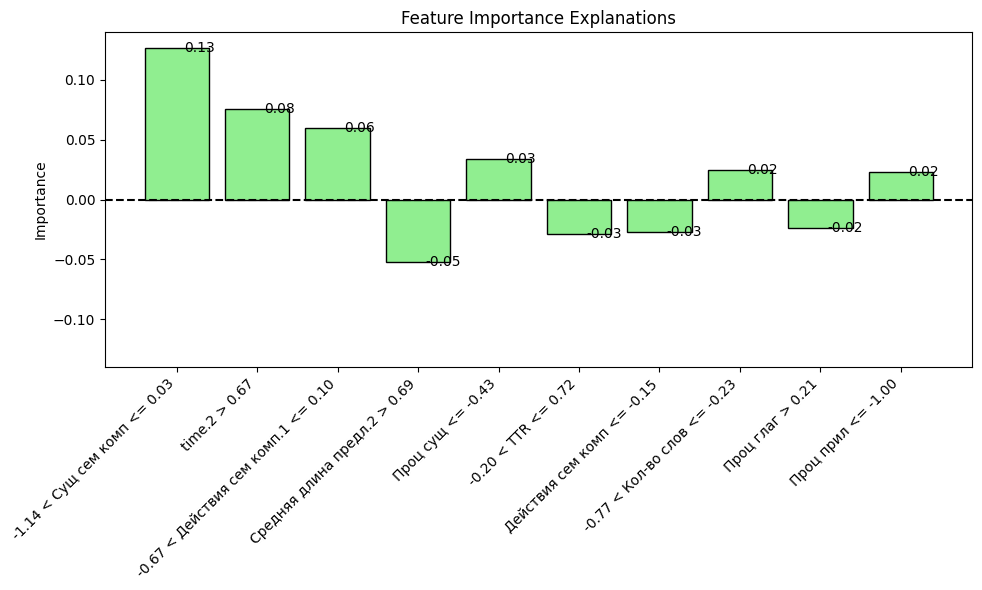

Explanations:
1: -1.14 < Сущ сем комп <= 0.03: 0.12701767994167223
2: time.2 > 0.67: 0.0752982481975436
3: -0.67 < Действия сем комп.1 <= 0.10: 0.05992534363481408
4: Средняя длина предл.2 > 0.69: -0.052010633886843585
5: Проц сущ <= -0.43: 0.034004377994495356
6: -0.20 < TTR <= 0.72: -0.02902145148376162
7: Действия сем комп <= -0.15: -0.027039132535622835
8: -0.77 < Кол-во слов <= -0.23: 0.02489356585941768
9: Проц глаг > 0.21: -0.023795210666189535
10: Проц прил <= -1.00: 0.023066296294784135


In [ ]:
import lime
import lime.lime_tabular
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

data = pd.read_csv('https://docs.google.com/spreadsheets/d/1_bYd5iRxzbC34bbTDlL_0aVbMKttACZAv4UkoDadu7o/export?format=csv&gid=1072126418', header=1)
data = data.drop(['is_strong.1', 'is_strong.2'], axis=1, errors='ignore')
df = pd.DataFrame(data)
X = df.drop('is_strong', axis=1)  # Признаки (DataFrame)
y = df['is_strong'].values  # Целевая переменная

# Стратифицированное разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Создание DataFrame с названиями столбцов
feature_names = X_train.columns.tolist()
X_train_df = pd.DataFrame(X_train, columns=feature_names)

# Масштабирование признаков
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)

# Классификация с помощью XGBoost
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train_scaled, y_train)

# Создание объекта LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=feature_names,
    class_names=['0', '1'],
    mode='classification'
)

# Получить список всех признаков из X_train
all_features = X_train.columns.tolist()

# Создать новый DataFrame с отсутствующими признаками, заполненными нулями
df_new = pd.DataFrame(data=np.zeros((1, len(all_features))), columns=all_features)

# Заполнить имеющиеся признаки в df_new
for feature in df_new.columns:
    if feature in df.columns:
        df_new[feature] = df[feature].values[0]

# Теперь df_new содержит все признаки
new_scaler = scaler.transform(df_new)

# Получение объяснения для нового объекта
instance = new_scaler[0].reshape(1, -1)  # Преобразование в одномерный массив
prediction = xgb_clf.predict_proba(instance)

# Вывод предсказанных вероятностей
print(f'New instance: {df_new.values[0]}')
print(f'Predicted probability for class 0: {prediction[0][0]}')
print(f'Predicted probability for class 1: {prediction[0][1]}')

explanation = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=xgb_clf.predict_proba
)

# Вывод объяснения
exp_list = explanation.as_list(label=1)

# Визуализация объяснений
feature_importance = [importance for _, importance in exp_list]
feature_names = [feature_name for feature_name, _ in exp_list]

fig, ax = plt.subplots(figsize=(10, 6))
x_pos = range(len(feature_names))

ax.bar(x_pos, feature_importance, align='center', color='lightgreen', edgecolor='black')
ax.set_xticks(x_pos)
ax.set_xticklabels(feature_names, rotation=45, ha='right')  # Наклон меток для лучшей читаемости
ax.set_ylabel('Importance')
ax.set_title('Feature Importance Explanations')

# Добавляем шкалу с положительными и отрицательными значениями
ax.axhline(0, color='black', linestyle='--')  # Горизонтальная линия через 0
ax.set_ylim(-np.max(np.abs(feature_importance)) * 1.1, np.max(np.abs(feature_importance)) * 1.1)  # Расширяем ось Y с запасом

# Добавляем аннотации с точными значениями важности
for i, importance in enumerate(feature_importance):
    ax.annotate(f'{importance:.2f}', xy=(x_pos[i], importance), xytext=(5, 0), textcoords='offset points', va='center', ha='left')

plt.tight_layout()
plt.show()

# Вывод текстового объяснения
print('Explanations:')
for i, (feature_name, importance) in enumerate(exp_list, start=1):
    print(f'{i}: {feature_name}: {importance}')

## Метод Shap

SHAP основан на концепции ценностей Шепли из теории кооперативных игр и позволяет получить более глобальные объяснения, чем LIME. Вот как работает SHAP:

1. Для каждого признака x'i вычисляется его шаплеевская ценность φi, которая показывает, насколько данный признак "вносит вклад" в изменение предсказания модели по сравнению с некоторой базовой моделью (например, средним предсказанием).

2. Вычисление φi выполняется путем перебора всех возможных коалиций признаков (подмножеств признаков) и вычисления для каждой коалиции, насколько она изменяет предсказание по сравнению с базовой моделью.

3. Затем шаплеевская ценность φi определяется как средневзвешенное этих изменений предсказания, где веса рассчитываются по специальным правилам теории кооперативных игр.

4. Сумма всех φi равна отклонению предсказания модели от базового, т.е. объясняет изменение полностью.

5. Значения φi визуализируются для каждого экземпляра или усредняются по всему набору данных.

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.0 MB/s eta 0:00:00


In [ ]:
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [ ]:
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(xgb_clf)

In [ ]:
shap_values = explainer.shap_values(df_new)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0], df_new)

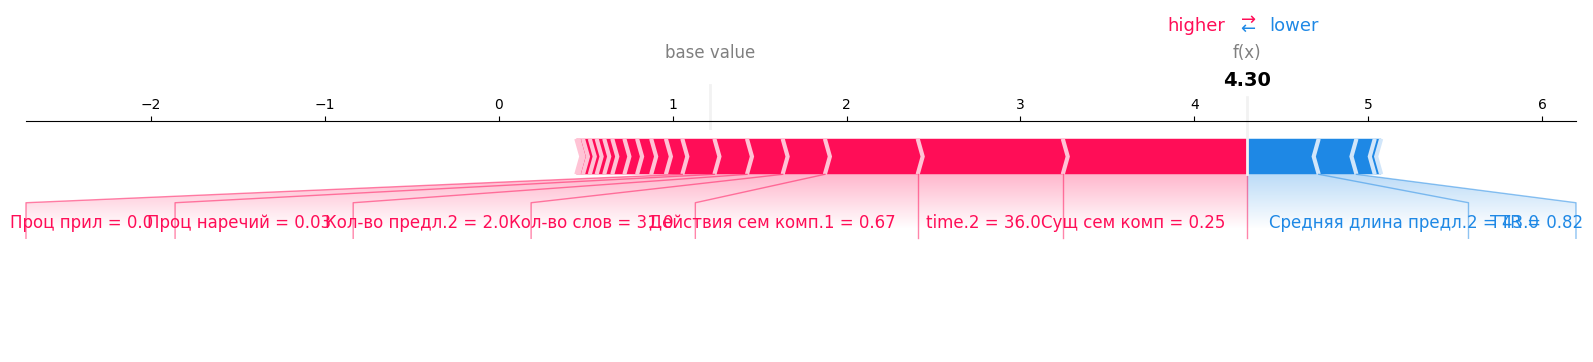

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0], df_new, matplotlib=True)

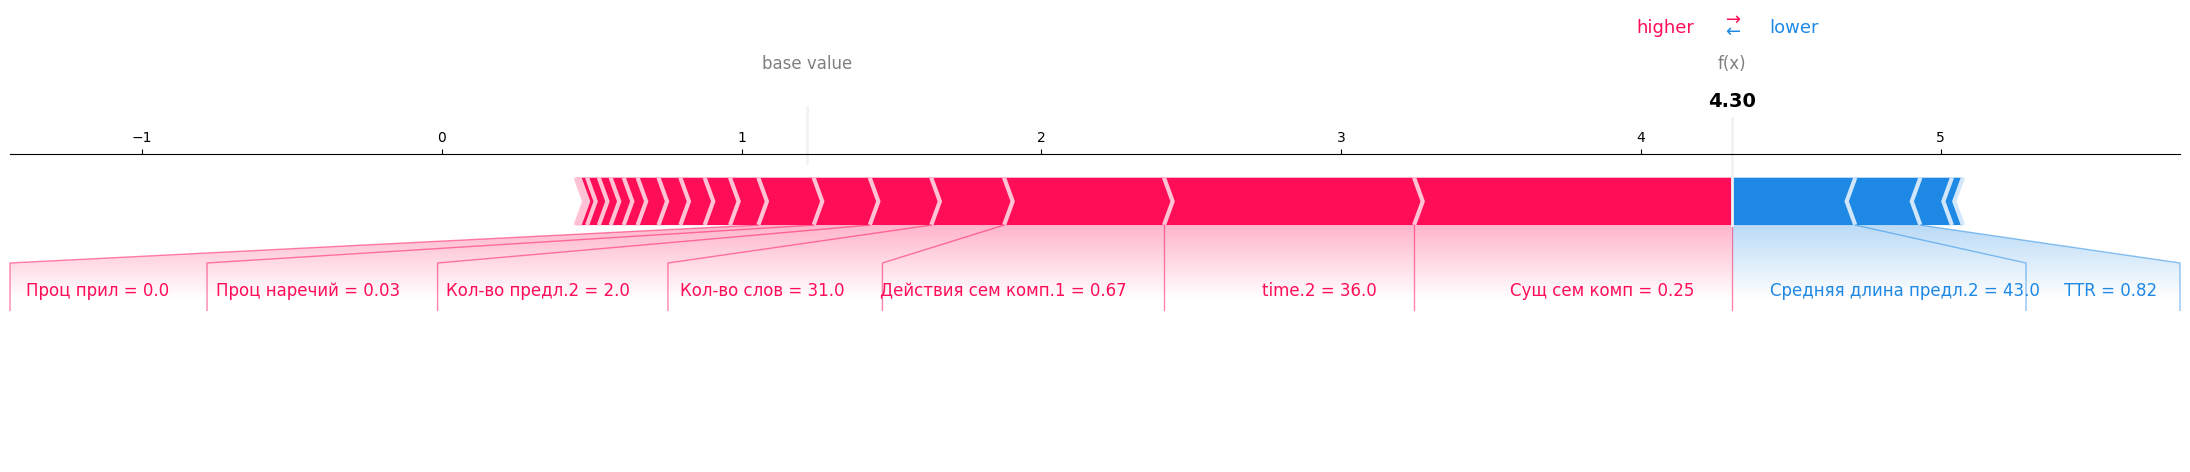

In [ ]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(df_new)

shap.force_plot(explainer.expected_value, shap_values[0], df_new, matplotlib=True, figsize=(28, 4))

plt.gcf().set_size_inches(8, 4)  # Устанавливаем размер рисунка
for item in ([plt.gca().xaxis.label, plt.gca().yaxis.label] + plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    item.set_fontsize(8)  # Устанавливаем размер шрифта

plt.savefig('shap_force_plot_compact.png', dpi=300, bbox_inches='tight')
plt.close()


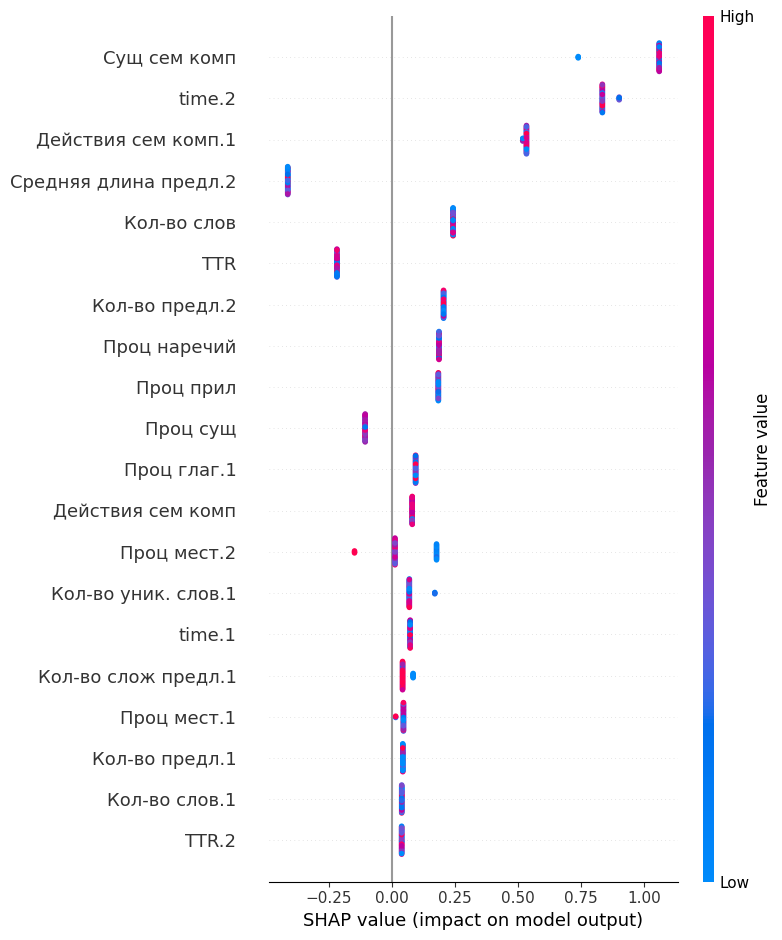

In [ ]:
import shap
import xgboost

explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

In [ ]:
# df_new = df_new.drop(['is_strong', 'is_strong.1', 'is_strong.2'], axis=1, errors='ignore')
# scaler = preprocessing.StandardScaler().fit(df_new)
# new_scaler = scaler.transform(df_new)

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

# Загрузка данных
data = pd.read_csv('https://docs.google.com/spreadsheets/d/1k4Gis2LwEHYzZjyXOTK-H5-zoR9u8MmN1YolsJMe7_k/export?format=csv', header=1)

# Заполнение пропущенных значений нулями
data = data.fillna(0)

# Масштабирование данных
scaler = preprocessing.StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data.drop(['is_strong', 'is_strong.1', 'is_strong.2'], axis=1, errors='ignore')), columns=data.drop(['is_strong', 'is_strong.1', 'is_strong.2'], axis=1, errors='ignore').columns)

# Добавление целевой переменной обратно к масштабированным данным
data_scaled['is_strong'] = data['is_strong']

X = data_scaled.drop('is_strong', axis=1)  # Признаки
y = data_scaled['is_strong']  # Целевая переменная

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

# Вычисление permutation importance
result = permutation_importance(model, X_test, y_test, scoring=accuracy_score, n_jobs=-1)
feature_importances = result.importances_mean

# Сортировка признаков по влиянию в порядке убывания
feature_names = X.columns
sorted_importances = sorted(zip(feature_importances, feature_names), reverse=True)

# Вывод результатов
print("Permutation importance признаков:")
for importance, feature in sorted_importances:
    print(f"{feature}: {importance:.3f}")


TypeError: too many positional arguments

In [ ]:
!pip install shap

In [ ]:
import shap
print(shap.__version__)


0.45.1


In [ ]:
import shap
import importlib
importlib.reload(shap)


<module 'shap' from '/usr/local/lib/python3.10/dist-packages/shap/__init__.py'>

In [ ]:
from shap import KMeansExplainer


ImportError: cannot import name 'KMeansExplainer' from 'shap' (/usr/local/lib/python3.10/dist-packages/shap/__init__.py)

In [ ]:
import shap
import pandas as pd


data = pd.read_csv('https://docs.google.com/spreadsheets/d/1k4Gis2LwEHYzZjyXOTK-H5-zoR9u8MmN1YolsJMe7_k/export?format=csv', header = 1)
scaler = preprocessing.StandardScaler().fit(data.fillna(0))
df_cor_scaled = scaler.transform(data.fillna(0))

explainer = shap.KMeansExplainer(model.cluster_centers_, df_cor_scaled)
shap_values = explainer.shap_values(df_new)
shap.summary_plot(shap_values, df_new)


ImportError: cannot import name 'KMeansExplainer' from 'shap' (/usr/local/lib/python3.10/dist-packages/shap/__init__.py)

In [ ]:
# import pandas as pd
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_samples
# from sklearn.preprocessing import StandardScaler

# # Загрузка данных
# data = pd.read_csv('https://docs.google.com/spreadsheets/d/1k4Gis2LwEHYzZjyXOTK-H5-zoR9u8MmN1YolsJMe7_k/export?format=csv', header=1)

# # Получение названий всех столбцов
# all_cols = data.columns

# # Вывод названий всех столбцов в данных
# print("Названия всех столбцов в данных:")
# print(all_cols)


Названия всех столбцов в данных:
Index(['Кол-во слов', 'Кол-во предл', 'Кол-во уник. слов', 'Кол-во слож предл',
       'Средняя длина предл', 'TTR', 'Проц прил', 'Проц наречий', 'Проц мест',
       'Проц сущ', 'Проц глаг', 'Семант полнота', 'Сущ сем комп',
       'Действия сем комп', 'time', 'is_strong', 'Кол-во слов.1',
       'Кол-во предл.1', 'Кол-во уник. слов.1', 'Кол-во слож предл.1',
       'Средняя длина предл.1', 'TTR.1', 'Проц прил.1', 'Проц наречий.1',
       'Проц мест.1', 'Проц сущ.1', 'Проц глаг.1', 'Семант полнота.1',
       'Сущ сем комп.1', 'Действия сем комп.1', 'time.1', 'is_strong.1',
       'Кол-во слов.2', 'Кол-во предл.2', 'Кол-во уник. слов.2',
       'Кол-во слож предл.2', 'Средняя длина предл.2', 'TTR.2', 'Проц прил.2',
       'Проц наречий.2', 'Проц мест.2', 'Проц сущ.2', 'Проц глаг.2',
       'Семант полнота.2', 'Сущ сем комп.2', 'Действия сем комп.2', 'time.2',
       'is_strong.2'],
      dtype='object')


двумерная рассеянная диаграмма

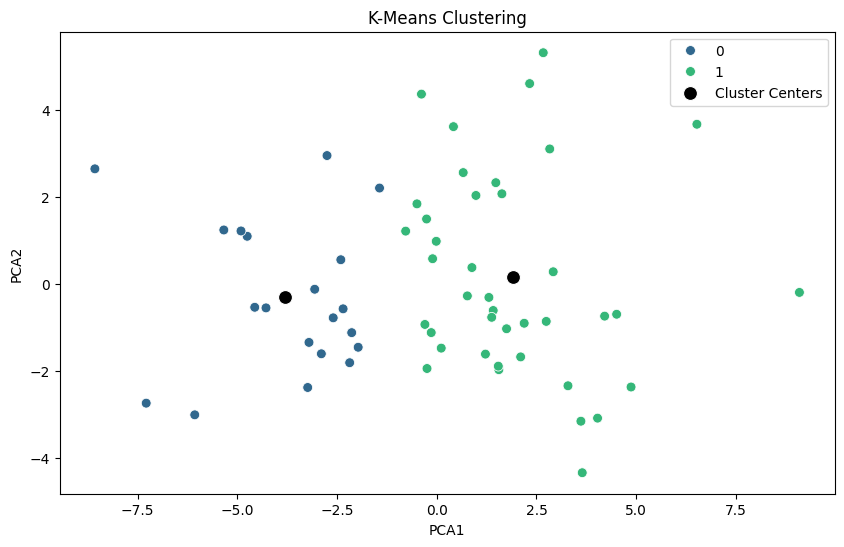

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Выполняем анализ главных компонент
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Создаем DataFrame с главными компонентами и метками кластеров
pca_data = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_data['Cluster'] = kmeans.labels_

# Создаем рассеянную диаграмму
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=pca_data, palette='viridis', s=50)

# Добавляем центроиды кластеров
cluster_centers = pca_data.groupby('Cluster')[['PCA1', 'PCA2']].mean().reset_index()
sns.scatterplot(x=cluster_centers['PCA1'], y=cluster_centers['PCA2'], markers='x', color='black', s=100, label='Cluster Centers')

plt.legend()
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('K-Means Clustering')

plt.show()

## итог

Подсчет количественных характеристик для нового ребенка

In [ ]:
df1 = pd.DataFrame({ "time1": [43], "is_strong": [1], "tell1": ["Я не помню имени маленького мальчика. однажды эти двое вернулись домой из школы. их мать сказала, что они собирались поесть в тот вечер . и она спросила их, куда они хотят пойти. они оба  кричали «Макдональдс». Когда они приехали, Лиза не могла решить, что хочет.  Итак, ее мать и брат уже знали, чего хотят. ее брат попросил ээ  когда он добрался до стойки, он попросил чизбургер с картошкой фри и ванильный молочный коктейль. их мать заказала немного салата. наконец-то Лиза смогла решить, чего она хочет. она попросила хэппи мил с рожком мороженого и колой. как раз в тот момент, когда их мать полезла в свою сумочку, чтобы достать сумку, его там не было. и она вспомнила, что оставила сумочку на дома."]})
df2 = pd.DataFrame({ "time2": [30], "is_strong": [1], "tell2": ["однажды маленький мальчик по имени Сэмми проснулся от того, что его будильник звонил очень-очень громко. он быстро спустился вниз, чтобы позавтракать. и как раз в тот момент, когда он наливал молоко в хлопья, он случайно пролил молоко на стол. после того, как он оделся в школу, его шнурки не слушались. и они бы вообще не связались. он собирался в школу идя по улице.  и его школьный автобус уезжал. он бежал за ним, но он не успел вовремя. так что ему пришлось идти в школу пешком. его учитель сказал, что он очень сильно опоздал ."]})
df3 = pd.DataFrame({ "time3": [36], "is_strong": [1], "tell3": ["Однажды двое детей шли по тропинке. Это было утро понедельника. они прошли мимо этого  леса. они решили отправиться туда ради небольшого приключения и, возможно, просто ради улиток, которых они еще не видели. они видели этих инопланетян. оба ребенка были напуганы, но девочка не очень-то испугалась. мальчик был в ужасе. Маргарет побежала к инопланетянам, пока Дэниел держал ее руку и говорил «нет». а потом инопланетяне прыгнули на корабль. и они просто разошлись всей семьей. но они пошли домой, отвели родителей к тому месту, где они видели <&~ar>[/] инопланетян, чтобы посмотреть, там ли они еще. родители сказали, что в это не очень легко поверить."]})


In [ ]:
df_new = pd.concat([get_df(df1, "1", semantic_components1),
                    get_df(df2, "2", semantic_components2),
                    get_df(df3, "3", semantic_components3)], axis=1)

Я не помню имени маленького мальчика. однажды эти двое вернулись домой из школы. их мать сказала, что они собирались поесть в тот вечер . и она спросила их, куда они хотят пойти. они оба  кричали «Макдональдс». Когда они приехали, Лиза не могла решить, что хочет.  Итак, ее мать и брат уже знали, чего хотят. ее брат попросил ээ  когда он добрался до стойки, он попросил чизбургер с картошкой фри и ванильный молочный коктейль. их мать заказала немного салата. наконец-то Лиза смогла решить, чего она хочет. она попросила хэппи мил с рожком мороженого и колой. как раз в тот момент, когда их мать полезла в свою сумочку, чтобы достать сумку, его там не было. и она вспомнила, что оставила сумочку на дома.
[['помнить', 'вернуться'], ['вернуться', 'однажды'], ['вернуться', 'двое'], ['двое', 'этот'], ['вернуться', 'домой'], ['помнить', 'спросить'], ['спросить', 'сказать'], ['сказать', 'мать'], ['сказать', 'собираться'], ['собираться', 'что'], ['собираться', 'они'], ['собираться', 'поесть'], ['поес

In [ ]:
new_columns = ['Кол-во слов', 'Кол-во предл', 'Кол-во уник. слов', 'Кол-во слож предл',
       'Средняя длина предл', 'TTR', 'Проц прил', 'Проц наречий', 'Проц мест',
       'Проц сущ', 'Проц глаг', 'Семант полнота', 'Сущ сем комп',
       'Действия сем комп', 'time', 'is_strong', 'Кол-во слов.1',
       'Кол-во предл.1', 'Кол-во уник. слов.1', 'Кол-во слож предл.1',
       'Средняя длина предл.1', 'TTR.1', 'Проц прил.1', 'Проц наречий.1',
       'Проц мест.1', 'Проц сущ.1', 'Проц глаг.1', 'Семант полнота.1',
       'Сущ сем комп.1', 'Действия сем комп.1', 'time.1', 'is_strong.1',
       'Кол-во слов.2', 'Кол-во предл.2', 'Кол-во уник. слов.2',
       'Кол-во слож предл.2', 'Средняя длина предл.2', 'TTR.2', 'Проц прил.2',
       'Проц наречий.2', 'Проц мест.2', 'Проц сущ.2', 'Проц глаг.2',
       'Семант полнота.2', 'Сущ сем комп.2', 'Действия сем комп.2', 'time.2',
       'is_strong.2']

# Переименовать столбцы
df_new.columns = new_columns

In [ ]:

df_new = df_new.drop(['is_strong','is_strong.1', 'is_strong.2'], axis=1, errors='ignore')

In [ ]:
df_new

,Кол-во слов,Кол-во предл,Кол-во уник. слов,Кол-во слож предл,Средняя длина предл,TTR,Проц прил,Проц наречий,Проц мест,Проц сущ,...,TTR.2,Проц прил.2,Проц наречий.2,Проц мест.2,Проц сущ.2,Проц глаг.2,Семант полнота.2,Сущ сем комп.2,Действия сем комп.2,time.2
0,122,3,67,1.0,40.666667,0.69,0.03,0.08,0.16,0.2,...,0.75,0.02,0.11,0.11,0.2,0.18,0.0,0.6,0.75,36


In [ ]:
import pandas as pd
import joblib
path_drive = "/content/gdrive/MyDrive/Diplom/"
filepath = path_drive + "xgb_clf2.joblib"
model = joblib.load(filepath)

In [ ]:
pred = model.predict(df_new)


In [ ]:
print(pred)

[1]


New instance: [3.1e+01 1.0e+00 1.8e+01 1.0e+00 3.1e+01 8.2e-01 0.0e+00 3.0e-02 2.3e-01
 1.3e-01 2.9e-01 0.0e+00 2.5e-01 5.0e-01 2.3e+01 3.9e+01 1.0e+00 2.2e+01
 0.0e+00 3.9e+01 8.8e-01 3.0e-02 1.3e-01 1.8e-01 1.8e-01 2.6e-01 0.0e+00
 5.6e-01 6.7e-01 1.7e+01 8.6e+01 2.0e+00 3.7e+01 1.0e+00 4.3e+01 5.8e-01
 6.0e-02 6.0e-02 1.7e-01 1.6e-01 1.6e-01 3.3e-01 5.0e-01 6.2e-01 3.6e+01]
Predicted probability for class 0: 0.01772892475128174
Predicted probability for class 1: 0.9822710752487183


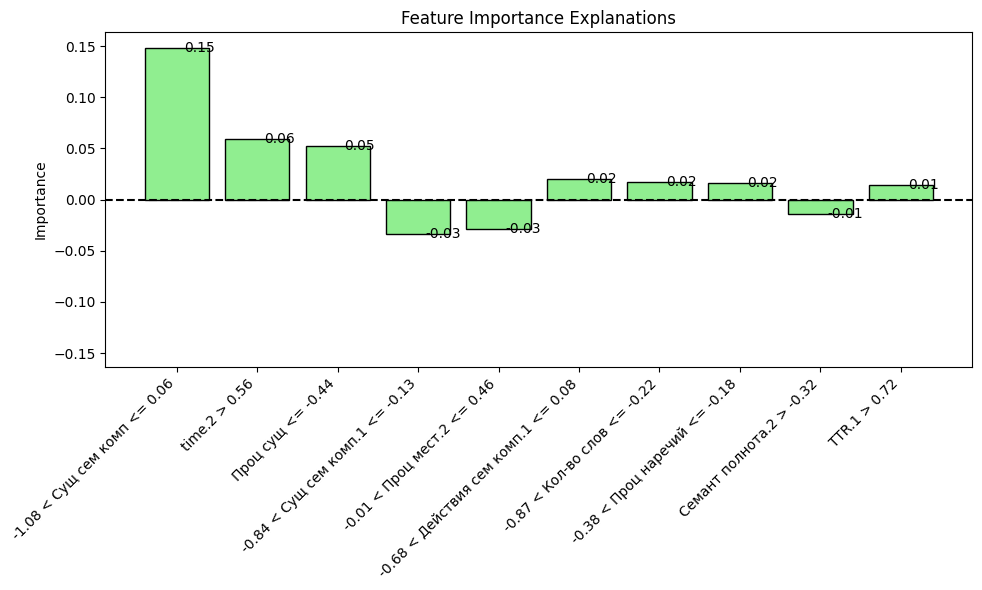

Explanations:
1: -1.08 < Сущ сем комп <= 0.06: 0.14851903824390622
2: time.2 > 0.56: 0.05871097263417059
3: Проц сущ <= -0.44: 0.05234616544602921
4: -0.84 < Сущ сем комп.1 <= -0.13: -0.03319059241764118
5: -0.01 < Проц мест.2 <= 0.46: -0.02846059090858602
6: -0.68 < Действия сем комп.1 <= 0.08: 0.019647307302118125
7: -0.87 < Кол-во слов <= -0.22: 0.0169774975517185
8: -0.38 < Проц наречий <= -0.18: 0.01659647564752775
9: Семант полнота.2 > -0.32: -0.014346980756874012
10: TTR.1 > 0.72: 0.01429706701091088


In [ ]:
import lime
import lime.lime_tabular
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

data = pd.read_csv('https://docs.google.com/spreadsheets/d/1_bYd5iRxzbC34bbTDlL_0aVbMKttACZAv4UkoDadu7o/export?format=csv&gid=1072126418', header=1)
data = data.drop(['is_strong.1', 'is_strong.2'], axis=1, errors='ignore')
df = pd.DataFrame(data)
X_train = df.drop('is_strong', axis=1)  # Признаки (DataFrame)
y = df['is_strong'].values  # Целевая переменная


# Создание DataFrame с названиями столбцов
feature_names = X_train.columns.tolist()
X_train_df = pd.DataFrame(X_train, columns=feature_names)

# Масштабирование признаков
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)


# Создание объекта LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=feature_names,
    class_names=['0', '1'],
    mode='classification'
)

# Получить список всех признаков из X_train
all_features = X_train.columns.tolist()


# Заполнить имеющиеся признаки в df_new
for feature in df_new.columns:
    if feature in df.columns:
        df_new[feature] = df[feature].values[0]

# Теперь df_new содержит все признаки
new_scaler = scaler.transform(df_new)

# Получение объяснения для нового объекта
instance = new_scaler[0].reshape(1, -1)  # Преобразование в одномерный массив
prediction = model.predict_proba(instance)

# Вывод предсказанных вероятностей
print(f'New instance: {df_new.values[0]}')
print(f'Predicted probability for class 0: {prediction[0][0]}')
print(f'Predicted probability for class 1: {prediction[0][1]}')

explanation = explainer.explain_instance(
    data_row=instance[0],
    predict_fn=model.predict_proba
)

# Вывод объяснения
exp_list = explanation.as_list(label=1)

# Визуализация объяснений
feature_importance = [importance for _, importance in exp_list]
feature_names = [feature_name for feature_name, _ in exp_list]

fig, ax = plt.subplots(figsize=(10, 6))
x_pos = range(len(feature_names))

ax.bar(x_pos, feature_importance, align='center', color='lightgreen', edgecolor='black')
ax.set_xticks(x_pos)
ax.set_xticklabels(feature_names, rotation=45, ha='right')  # Наклон меток для лучшей читаемости
ax.set_ylabel('Importance')
ax.set_title('Feature Importance Explanations')

# Добавляем шкалу с положительными и отрицательными значениями
ax.axhline(0, color='black', linestyle='--')  # Горизонтальная линия через 0
ax.set_ylim(-np.max(np.abs(feature_importance)) * 1.1, np.max(np.abs(feature_importance)) * 1.1)  # Расширяем ось Y с запасом

# Добавляем аннотации с точными значениями важности
for i, importance in enumerate(feature_importance):
    ax.annotate(f'{importance:.2f}', xy=(x_pos[i], importance), xytext=(5, 0), textcoords='offset points', va='center', ha='left')

plt.tight_layout()
plt.show()

# Вывод текстового объяснения
print('Explanations:')
for i, (feature_name, importance) in enumerate(exp_list, start=1):
    print(f'{i}: {feature_name}: {importance}')

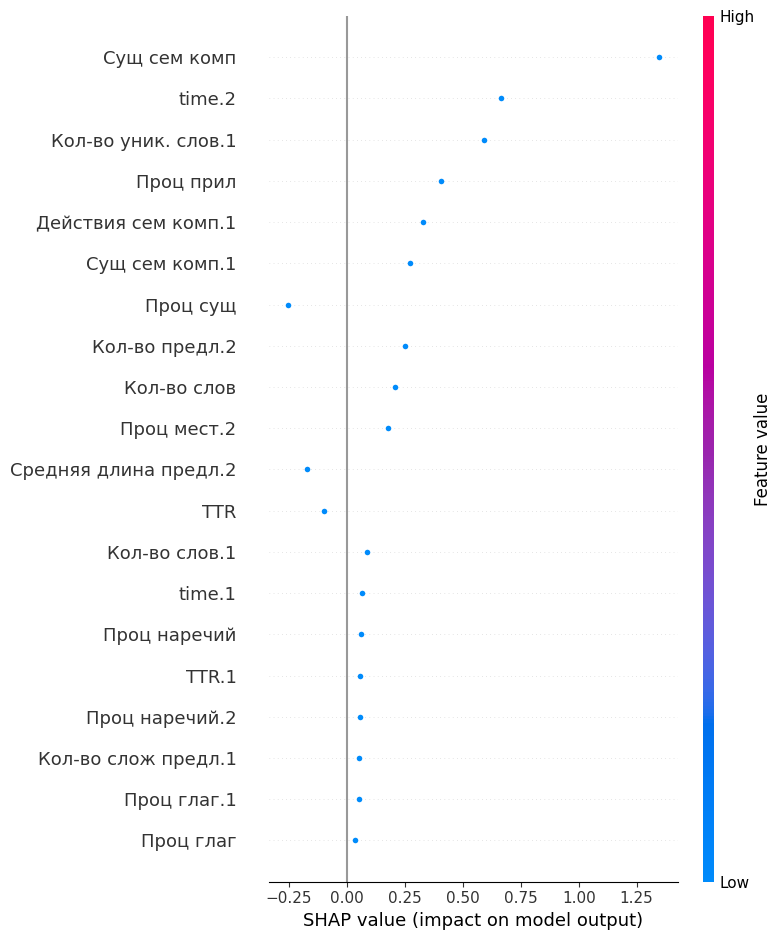

In [ ]:
import shap
import xgboost

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_new)

shap.summary_plot(shap_values, df_new)

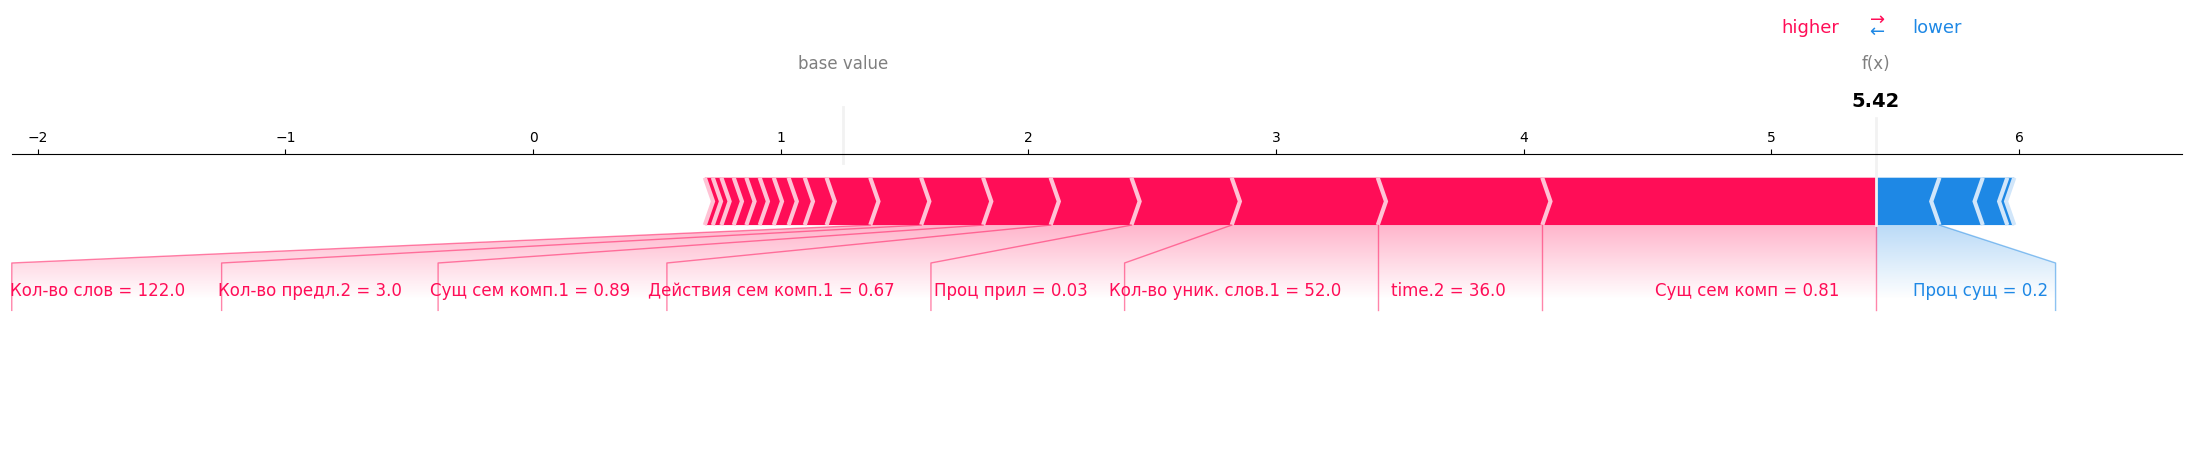

In [ ]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_new)

shap.force_plot(explainer.expected_value, shap_values[0], df_new, matplotlib=True, figsize=(28, 4))

plt.gcf().set_size_inches(8, 4)  # Устанавливаем размер рисунка
for item in ([plt.gca().xaxis.label, plt.gca().yaxis.label] + plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    item.set_fontsize(8)  # Устанавливаем размер шрифта

plt.savefig('shap_force_plot_compact.png', dpi=300, bbox_inches='tight')
plt.close()

In [ ]:

df_new = df_new.drop(['is_strong','is_strong.1', 'is_strong.2','time.1', 'time.2','time'], axis=1, errors='ignore')

In [ ]:
import pandas as pd
import joblib
path_drive = "/content/gdrive/MyDrive/Diplom/"
filepath = path_drive + "xgb_clf3.joblib"
model_xgb = joblib.load(filepath)

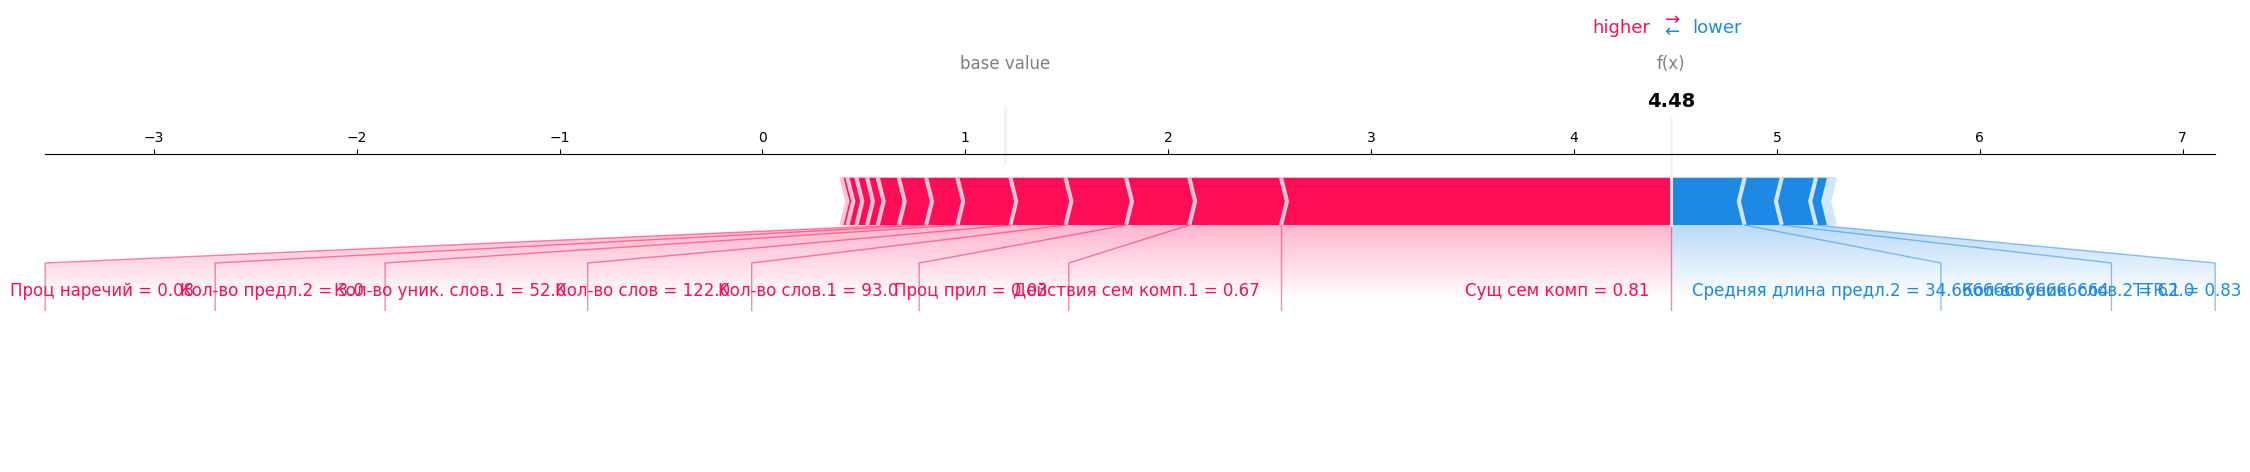

In [ ]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(df_new)

shap.force_plot(explainer.expected_value, shap_values[0], df_new, matplotlib=True, figsize=(28, 4))

plt.gcf().set_size_inches(8, 4)  # Устанавливаем размер рисунка
for item in ([plt.gca().xaxis.label, plt.gca().yaxis.label] + plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    item.set_fontsize(8)  # Устанавливаем размер шрифта

plt.savefig('shap_force_plot_compact.png', dpi=300, bbox_inches='tight')
plt.close()

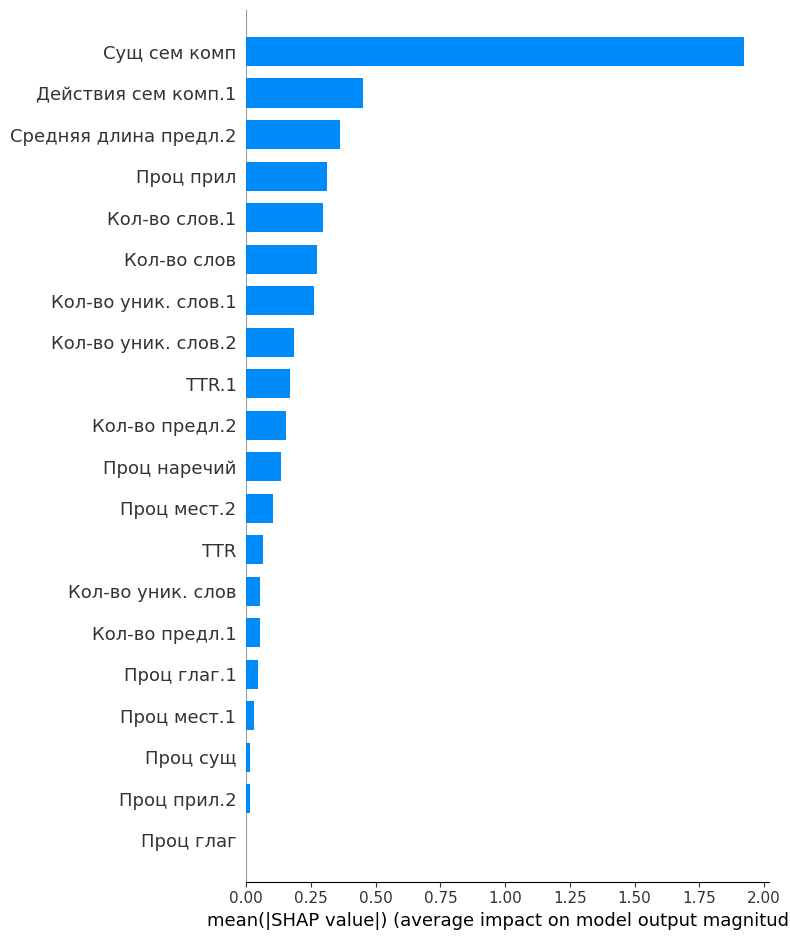

In [ ]:
shap.summary_plot(shap_values, df_new, plot_type="bar")


In [ ]:
pip freeze > requirements.txt